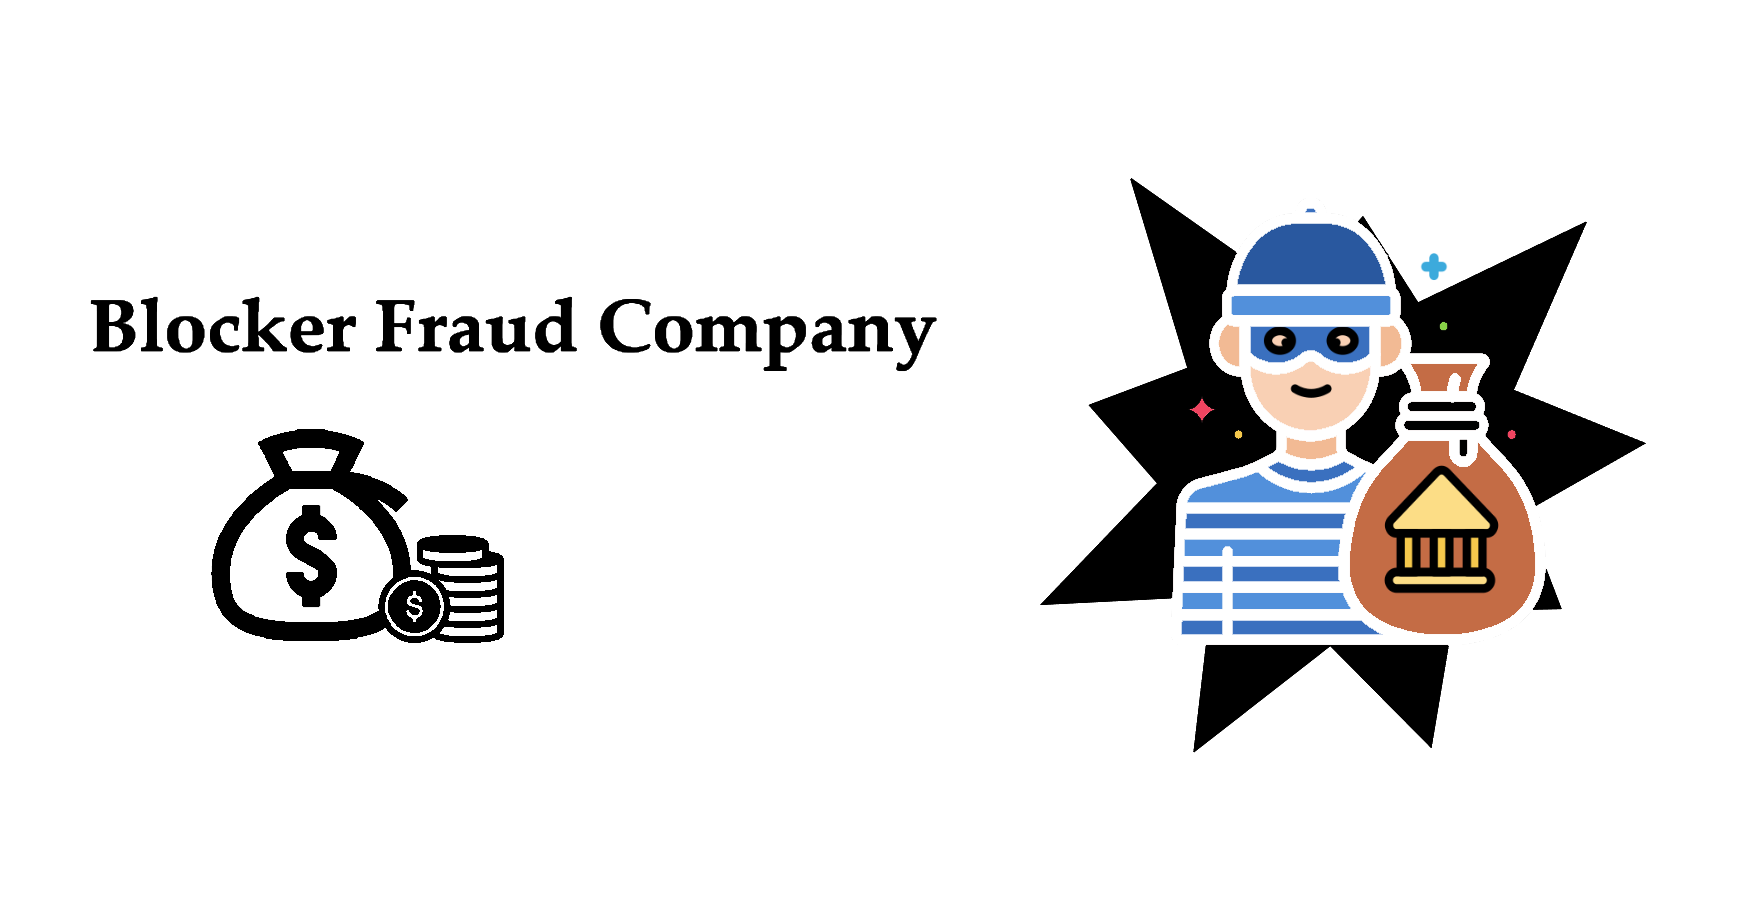

<p style="text-align:center;"><i>"Blocker Fraude Company is a company specialized in fraud detection in financial transactions made through mobile devices. The company has a service called “Blocker Fraud” with guarantee of blocking fraudulent transactions."</i></p>

**Bussiness Model**

The company's business model is of the service type with monetization made by the provider's performance, that is, the user pays a fixed fee on the success in the detection of service fraud of the customer's transactions.

In Brazil, the company start with a new method of services to get some new clients:

1. The company will receive **25%** of the value of each transaction that is **truly detected as fraud**.
2. The company will receive **5%** of the value of each transaction **detected as fraud, however the transaction is truly legitimate**.
3. The company will refund **100%** of the value to the customer, for each transaction **detected as legitimate, however the transaction is truly a fraud**.

**What is a Fraud?**

<i>"Wrongful or criminal deception intended to result in financial or personal gain."</i>~ Wiki

Fraud is an intentionally deceptive action designed to provide the perpetrator with an unlawful gain or to deny a right to a victim. In addition, it is a deliberate act (or failure to act) with the intention of obtaining an unauthorized benefit, either for oneself or for the institution, by using deception or false suggestions or suppression of truth or other unethical means, which are believed and relied upon by others. Depriving another person or the institution of a benefit to which he/she/it is entitled by using any of the means described above also constitutes fraud.

Types of fraud include tax fraud, credit card fraud, wire fraud, securities fraud, and bankruptcy fraud. Fraudulent activity can be carried out by one individual, multiple individuals or a business firm as a whole.

Source data set: https://www.kaggle.com/ntnu-testimon/paysim1

| Feature        | Description                                                                                                                                                                                                                                                                                           |
|:----------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| step           | maps a unit of time in the real world\. In this case 1 step is 1 hour of time\. Total steps 744 \(30 days simulation\)\.                                                                                                                                                                              |
| type           | Transaction type \(CASH\-IN, CASH\-OUT, DEBIT, PAYMENT and TRANSFER\)                                                                                                                                                                                                                                 |
| amount         | amount of the transaction in local currency                                                                                                                                                                                                                                                           |
| nameOrig       | customer who started the transaction                                                                                                                                                                                                                                                                  |
| oldbalanceOrg  | initial balance before the transaction                                                                                                                                                                                                                                                                |
| newbalanceOrig | new balance after the transaction                                                                                                                                                                                                                                                                     |
| nameDest       | customer who is the recipient of the transaction                                                                                                                                                                                                                                                      |
| oldbalanceDest | initial balance recipient before the transaction\. Note that there is not information for customers that start with M \(Merchants\)                                                                                                                                                                   |
| newbalanceDest | new balance recipient after the transaction\. Note that there is not information for customers that start with M \(Merchants\)                                                                                                                                                                        |
| isFraud        | This is the transactions made by the fraudulent agents inside the simulation\. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system |
| isFlaggedFraud | The business model aims to control massive transfers from one account to another and flags illegal attempts\. An illegal attempt in this dataset is an attempt to transfer more than 200K in a single transaction                                                                                 |

### 0.1. Imports

In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from random import choices
from scipy import stats as ss
from inflection import underscore

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, RobustScaler 

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_confusion_matrix, plot_calibration_curve, cumulative_gain_curve, plot_cumulative_gain
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, roc_auc_score, precision_recall_curve

#from pyspark.sql import SparkSession
#from pyspark.sql.functions import format_number, skewness, kurtosis, col, when, isnan, count
#from pyspark.sql.types import StructField, StringType, ShortType, DoubleType, StructType, IntegerType

### 0.2. Aux Functions

In [2]:
dtypes = {'step': 'int16',
          'type': 'category',
          'amount': 'float32',
          'nameOrig': 'object',
          'oldbalanceOrg': 'float32',
          'newbalanceOrig': 'float32',
          'nameDest': 'object',
          'oldbalanceDest': 'float32',
          'newbalanceDest': 'float32',
          'isFraud': 'uint8',
          'isFlaggedFraud': 'uint8'}

warnings.filterwarnings('ignore')

def args_b(color=(1, 1, 1, 0), edgecolor='red', linewidth=3):
    return {'linewidth': linewidth, 'color': color, 'edgecolor': edgecolor}

def args(bins=np.arange(0, 2, 1), hstep='step', lwidth=3, c='r', label='Fraud', normed=False):
    return {'bins': bins, 'histtype': hstep, 'linewidth': lwidth, 'color': c, 'density': normed, 'label': label}

palette = sns.diverging_palette(359, 359, n=5, s=999, l=50, center='dark')

def metrics(df, prop=.25, split=False):
    num_att = df.select_dtypes(include=['int16', 'float32'])
    cat_att = df.select_dtypes(include=['object', 'category'])
    
    if split:
        return num_att, cat_att
    
    else:        
        c1 = pd.DataFrame(num_att.apply(np.mean)).T
        c2 = pd.DataFrame(num_att.apply(np.median)).T
        d1 = pd.DataFrame(num_att.apply(min)).T
        d2 = pd.DataFrame(num_att.apply(max)).T
        d3 = pd.DataFrame(num_att.apply(np.std)).T
        d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T
        trim_mean = pd.DataFrame(ss.trim_mean(num_att.values, .25)).T
        trim_mean.columns = d6.columns.tolist()

        m = pd.concat([d1, d2, c1, c2, trim_mean, d3, d4, d5, d6], axis=0).T.reset_index()
        m.columns = ['att', 'min', 'max', 'mean', 'median', 'trim_mean', 'std', 'range', 'skew', 'kurtosis']

        return m
    
def feature_engineering(df):
    df['day'] = np.ceil(df.step / 24).astype('int16')

    df['merch_flag'] = df['name_dest'].apply(lambda x: 1 if x.startswith("M") else 0)

    df['amount_per_day'] = df['amount'] / df['day']

    df['diff_org'] = df['oldbalance_org'] - df['amount'] - df['newbalance_orig']

    df['diff_dest'] = df['oldbalance_dest'] + df['amount'] - df['newbalance_dest']
    
    return df

def data_preparation(df):
    f_type = {'CASH_IN': 0.11240392073901699, 'CASH_OUT': 0.4262040758761723, 'DEBIT': 0.0028911924405895214, 'PAYMENT': 0.16825329666455116, 'TRANSFER': 0.29024751427967}
    amount_scaler = pickle.load( open("amount_scaler.pkl", "rb") )
    diff_org_scaler = pickle.load( open("diff_org_scaler.pkl", "rb") )
    diff_dest_scaler = pickle.load( open("diff_dest_scaler.pkl", "rb") )
    oldbalance_org_scaler = pickle.load( open("oldbalance_org_scaler.pkl", "rb") )
    newbalance_orig_scaler = pickle.load( open("newbalance_orig_scaler.pkl", "rb") )
    newbalance_dest_scaler = pickle.load( open("newbalance_dest_scaler.pkl", "rb") )
    
    df.type = df.type.apply(lambda x: f_type[x])
    
    df['amount'] = amount_scaler.transform(df[['amount']])
    df['diff_org'] = diff_org_scaler.transform(df[['diff_org']])
    df['diff_dest'] = diff_dest_scaler.transform(df[['diff_dest']])
    df['oldbalance_org'] = oldbalance_org_scaler.transform(df[['oldbalance_org']])
    df['newbalance_orig'] = newbalance_orig_scaler.transform(df[['newbalance_orig']])
    df['newbalance_dest'] = newbalance_dest_scaler.transform(df[['newbalance_dest']])
    
    return df
    
def simple_plot_bars(cat_values):
    _, _, = plt.subplots(figsize=(10,10))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1))

    ax0.bar(cat_values[0].keys(), cat_values[0].values(), color='k')
    ax1.hist(cat_values[1].values(), bins=10, color='k')
    ax2.hist(cat_values[2].values(), bins=10, color='k')
    ax0.set_title('type')
    ax1.set_title('name_origin')
    ax2.set_title('name_dest');
    
    return None

def plot_vars(df, feature, args_b=args_b):
    msk = (df.is_fraud == 1)
    _, _, = plt.subplots(figsize=(10,10))
    ax0 = plt.subplot2grid((2, 2), (0, 0))
    ax1 = plt.subplot2grid((2, 2), (0, 1))
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

    ax0.scatter(df[msk].day, df[msk][feature], **args_b(linewidth=1, edgecolor='k'))
    ax1.scatter(df[~msk].day, df[~msk][feature], **args_b(linewidth=1, edgecolor='r'));
    sns.scatterplot(df.day, df[feature], hue=df.is_fraud);

    ax0.set_title("With Fraud")
    ax1.set_title("Without Fraud")
    ax2.set_title("Full Dataset");
    
    return None

def plot_qq(a):
    msk = (a.is_fraud == 1)
    loga = np.log1p(a)
    loga = loga.fillna(0)
    loga.diff_org = loga.diff_org.astype("str").replace("-inf", '0').astype('float32')
    loga.diff_dest = loga.diff_dest.astype("str").replace("-inf", '0').astype('float32')
    
    for k in loga.columns.tolist():
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].hist(loga[msk][k], **args(bins=50, c='k'))
        ax[1].hist(loga[~msk][k], **args(bins=50, c='r'));
        ss.probplot(loga[k], plot=ax[2]);
        ax[2].text(.1, .9, k, color='maroon', transform=ax[2].transAxes)
        ax[0].set_title("With Fraud")
        ax[1].set_title("Without Fraud")
        
def point_bi(a, b, ax=None):
    
    a_v = a.values.reshape(-1)
    b_v = b.values.reshape(-1)
    
    ss.pointbiserialr(a_v, b_v)
    c = np.corrcoef(a_v, b_v)
    
    df = pd.DataFrame(c, columns=[a.name, b.name], index=[a.name, b.name])
    
    if not ax:
        fig, ax = plt.subplots(figsize=(6,5))
        sns.heatmap(df, annot=True, ax=ax).set_title(f"{a.name} -> {b.name}")
    
    else:
        sns.heatmap(df, annot=True, ax=ax).set_title(f"{a.name} -> {b.name}")
        
def plot_before_days(aux2, aux3, aux4):
    _, _, plt.subplots(figsize=(15,10))
    ax0 = plt.subplot2grid((2,2), (0,0))
    ax1 = plt.subplot2grid((2,2), (0,1))
    ax2 = plt.subplot2grid((2,2), (1,0), colspan=3)

    ax0.pie(aux2.is_fraud, labels=['After 20 Days', 'Before 20 Days'], explode=[.03, .01], colors=['k', 'r']);
    point_bi(aux4.is_fraud, aux4.amount, ax=ax1)
    ax2.bar(aux3.day, aux3.amount, **args_b(edgecolor='k'))
    ax2.vlines(20, 1, max(aux3.amount), linestyles='--');
    ax2.set_title("Amount Fraud per Day")
    ax2.set_ylabel('Amount')
    ax2.set_xlabel('Days');

def plot_trans_type(aux1, aux2, aux3, aux4):
    _, _, plt.subplots(figsize=(15,10))
    ax0 = plt.subplot2grid((2,3), (0,0))
    ax1 = plt.subplot2grid((2,3), (0,1))
    ax2 = plt.subplot2grid((2,3), (0,2))
    ax3 = plt.subplot2grid((2,3), (1,0), colspan=3)

    ax0.bar(aux1.type, aux1.is_fraud, color='k')
    ax1.bar(aux3.type, aux3.is_fraud, color='k')
    sns.violinplot(aux4.type, aux4.amount, ax=ax2)
    sns.scatterplot(aux2.day, aux2.is_fraud, hue=aux2.type)

    ax0.set_title("Only Fraud Transactions")
    ax0.set_ylabel("Fraud Count")
    ax1.set_title("No Fraud Transactions")
    ax2.set_title("Fraud Violin Type")
    ax3.set_title("Fraud per Day");
    
def plot_dest_amount(aux1, aux2, aux31):
    _, _ = plt.subplots(1, 2, figsize=(12, 10))
    ax0 = plt.subplot2grid((2,2), (0,0))
    ax1 = plt.subplot2grid((2,2), (0,1))
    ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)

    sns.countplot(aux1.cut_dest, **args_b(linewidth=2), ax=ax0)
    sns.barplot(aux2.cut_dest, aux2.amount, **args_b(edgecolor='navy', linewidth=2), ax=ax1)
    sns.barplot(aux31.cut_amount, aux31.percentage, hue=aux31.is_fraud, palette=palette)

    for t, a in zip(["Amount per Bins","Old Balance Destination Bins","Fraud per Bin"], [ax1, ax0, ax2]):
        a.set_title(t)
        a.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    
def get_features_importance(model, X):
    features = {k: v for k, v in zip(X.columns.tolist(), model.feature_importances_)}

    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(features.keys(), features.values(), color='k')
    ax.tick_params(axis='x', rotation=80)
    ax.set_title(type(model).__name__ + ' Feature Importance');
    
    return None

def plot_pattern(x=[1], y=[0], xlabel='x', ylabel='y', 
                 title='Fraud', model_name='', 
                 ax=False, pr=False, cumu=False):
    
    if ax == False:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    if not cumu:
        if pr: ax.plot([0,1], [1,0], 'k--', label='Random');

        else: ax.plot([1,0], [1,0], 'k--', label='Random');

        ax.plot(x, y, 'b', lw=3, label=f"Model {model_name}")
    
    else: ax.plot([0,1], [0,1], 'k--', label='Random');
    
    ax.set_xlim([0., 1.])
    ax.set_ylim([0., 1.])

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.grid('on')
    ax.legend(loc='lower right')
    
    return ax

def plot_roc_curve(y_true, yhat_proba, model_name="Baseline", ax=False):
    fpr, tpr, _ = roc_curve(y_true, yhat_proba[:, 1])
    
    ax = plot_pattern(fpr, tpr, xlabel="False Positive Rate", ylabel="True Positive Rate", 
                      title="ROC Curve", model_name=model_name, ax=ax)
    
    return ax

def plot_pr_curve(y_true, yhat_proba, model_name='Baseline', ax=False):
    pre, rec, tr = precision_recall_curve(y_true, yhat_proba[:, 1])
    pre, rec = [0]+list(pre), [1]+list(rec)
    
    ax = plot_pattern(rec, pre, xlabel="Recall", ylabel="Precision", 
                      title="PR Curve", model_name=model_name, ax=ax, pr=True)
    
    return ax

def cumulative_gain(y_true, y_score, l):
    
    y_true = (y_true == l)
    
    try:
        y_true = np.array(y_true)
    except:
        raise AttributeError("I Ca not convert y_ to np.array")
        
    index = np.argsort(y_score)
    y_true = y_true[index]

    gains = np.cumsum(y_true) / float(np.sum(y_true)) 
    percentages = np.arange(start=1, stop=len(y_true) + 1) / float(len(y_true))

    return percentages, gains

def plot_cumulative(y_true, y_probas, title='Cumulative Curve', model_name="Model Baseline", ax=None): # Do Not Need Model Name
    percentages, gains1 = cumulative_gain(y_true, y_probas[:, 0], 1)
    percentages, gains2 = cumulative_gain(y_true, y_probas[:, 1], 0)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    for k in zip([percentages, percentages], [gains1, gains2], ['b', 'r'], ['Class 0', 'Class 1']):
        ax.plot(k[0], k[1], lw=3, color=k[2], label=k[3])
        
    ax = plot_pattern(xlabel="Sample Size", ylabel="Proportion Fraud", title="Cumulative Gains", 
                      model_name=model_name, ax=ax, cumu=True) 
    
    return ax

def ml_error(model_name, ytrue, yhat, yprob=[1], plots=True):
    acc = accuracy_score(yhat, ytrue)
    pre = precision_score(yhat, ytrue)
    rec = recall_score(yhat, ytrue)
    fon = f1_score(yhat, ytrue)

    if plots:
        fig, ax = plt.subplots(2, 2, figsize=(7,7))
        ax = ax.flatten()
        
        plot_roc_curve(ytrue, yprob, model_name=model_name, ax=ax[0])
        plot_cumulative(ytrue, yprob, model_name=model_name, ax=ax[1])
        plot_pr_curve(ytrue, yprob, model_name=model_name, ax=ax[2])
        plot_confusion_matrix(yhat, ytrue, ax=ax[3])
        
        plt.tight_layout()
        
    else:
        plot_confusion_matrix(yhat, ytrue)

    df_res = pd.DataFrame([model_name, acc, pre, rec, fon]).T.rename(columns={0:'Model Name', 1:'Accuracy', 2:'Precision', 3:'Recall', 4:'F1-Score'})
    
    return df_res

In [19]:
# Startup PySpark Config
spark = SparkSession.builder.config("spark.driver.memory", "12g").appName('Fraud').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enables", "true")

### 0.3. Load Dataset 

In [21]:
# defines the schema:      field,   type,   Null.
data_schema = [StructField('step', ShortType(), True), 
               StructField('type', StringType(), True),
               StructField('amount', DoubleType(), True),
               StructField('nameOrig', StringType(), True),
               StructField('oldbalanceOrg', DoubleType(), True),
               StructField('newbalanceOrig', DoubleType(), True),
               StructField('nameDest', StringType(), True),
               StructField('oldbalanceDest', DoubleType(), True),
               StructField('newbalanceDest', DoubleType(), True),
               StructField('isFraud', ShortType(), True),
               StructField('isFlaggedFraud', ShortType(), True)]

final_struct = StructType(fields=data_schema)

In [23]:
df_spark = spark.read.csv('../data/data.csv', schema=final_struct, header=True)

In [25]:
df_spark.printSchema()

root
 |-- step: short (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: short (nullable = true)
 |-- isFlaggedFraud: short (nullable = true)



In [15]:
df_default = pd.read_csv('../data/data.csv')

In [26]:
df_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [2]:
dtypes = {'step': 'int16',
          'type': 'category',
          'amount': 'float32',
          'nameOrig': 'object',
          'oldbalanceOrg': 'float32',
          'newbalanceOrig': 'float32',
          'nameDest': 'object',
          'oldbalanceDest': 'float32',
          'newbalanceDest': 'float32',
          'isFraud': 'uint8',
          'isFlaggedFraud': 'uint8'}

df_pandas = pd.read_csv('../data/data.csv', dtype=dtypes)

In [3]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int16   
 1   type            category
 2   amount          float32 
 3   nameOrig        object  
 4   oldbalanceOrg   float32 
 5   newbalanceOrig  float32 
 6   nameDest        object  
 7   oldbalanceDest  float32 
 8   newbalanceDest  float32 
 9   isFraud         uint8   
 10  isFlaggedFraud  uint8   
dtypes: category(1), float32(5), int16(1), object(2), uint8(2)
memory usage: 248.8+ MB


In [4]:
df_pandas.sample()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1263167,134,CASH_IN,84805.5,C543757573,7330856.0,7415661.5,C231012766,1558012.625,1473207.125,0,0


### 0.4. Split Dataset in Train and Test

In [14]:
(df_pandas.isFraud.value_counts() / len(df_pandas))

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [16]:
strat = StratifiedShuffleSplit(n_splits=1, test_size=.15)
for train_index1, train_index2 in strat.split(df_pandas, df_pandas.isFraud):
    strat_train = df_pandas.loc[train_index1]
    strat_test  = df_pandas.loc[train_index2]

In [21]:
strat_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5408227 entries, 1528246 to 6295869
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int16   
 1   type            category
 2   amount          float32 
 3   nameOrig        object  
 4   oldbalanceOrg   float32 
 5   newbalanceOrig  float32 
 6   nameDest        object  
 7   oldbalanceDest  float32 
 8   newbalanceDest  float32 
 9   isFraud         uint8   
 10  isFlaggedFraud  uint8   
dtypes: category(1), float32(5), int16(1), object(2), uint8(2)
memory usage: 252.7+ MB


In [26]:
strat_train.isFraud.value_counts()

0    5401246
1       6981
Name: isFraud, dtype: int64

In [19]:
strat_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954393 entries, 3666544 to 1626565
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   step            954393 non-null  int16   
 1   type            954393 non-null  category
 2   amount          954393 non-null  float32 
 3   nameOrig        954393 non-null  object  
 4   oldbalanceOrg   954393 non-null  float32 
 5   newbalanceOrig  954393 non-null  float32 
 6   nameDest        954393 non-null  object  
 7   oldbalanceDest  954393 non-null  float32 
 8   newbalanceDest  954393 non-null  float32 
 9   isFraud         954393 non-null  uint8   
 10  isFlaggedFraud  954393 non-null  uint8   
dtypes: category(1), float32(5), int16(1), object(2), uint8(2)
memory usage: 44.6+ MB


In [25]:
strat_test.isFraud.value_counts()

0    953161
1      1232
Name: isFraud, dtype: int64

In [28]:
strat_train.to_csv("../data_backup/df_train.csv")
strat_test.to_csv("../data_backup/df_test.csv")

# 1.0. Descriptive Statistical

In [4]:
dtypes = {'step': 'int16',
          'type': 'category',
          'amount': 'float32',
          'nameOrig': 'object',
          'oldbalanceOrg': 'float32',
          'newbalanceOrig': 'float32',
          'nameDest': 'object',
          'oldbalanceDest': 'float32',
          'newbalanceDest': 'float32',
          'isFraud': 'uint8',
          'isFlaggedFraud': 'uint8'}

df = pd.read_csv("../data_backup/df_train.csv", dtype=dtypes)
df = df.drop("Unnamed: 0", axis=1)
msk = (df.isFraud == 1)

## 1.1. Rename Columns

In [5]:
df.columns = [underscore(k) for k in df.columns.tolist()]

## 1.2. Dataset Dimension

In [6]:
print(f'Number of Columns: {df.shape[1]}\nNumber of Rows: {df.shape[0]}')

Number of Columns: 11
Number of Rows: 5408227


## 1.3. Change Data Types

In [7]:
df.dtypes

step                   int16
type                category
amount               float32
name_orig             object
oldbalance_org       float32
newbalance_orig      float32
name_dest             object
oldbalance_dest      float32
newbalance_dest      float32
is_fraud               uint8
is_flagged_fraud       uint8
dtype: object

## 1.4. Check NaN

In [8]:
df.isna().sum() / len(df)

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

## 1.5. Fillout NaN

Do not have Missing Values

## 1.6. Change Data Types

Do not need change data types.

## 1.7. Undersampling Dataset

In [13]:
df.is_fraud.value_counts()

0    5401246
1       6981
Name: is_fraud, dtype: int64

In [18]:
df_samp = df.loc[df.is_fraud == 0].sample(7200)
df_samp = pd.concat([df_samp, df.loc[df.is_fraud == 1]], axis=0)
df_samp.head(3)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
5392399,34,CASH_OUT,408470.46875,C486135548,29238.0,0.0,C375056093,5.212254e+05,9.296959e+05,0,0
843123,206,CASH_IN,85954.21875,C1200329934,8539690.0,8625644.0,C1176483839,1.483390e+05,6.238476e+04,0,0
3710458,132,CASH_OUT,348976.31250,C872262965,0.0,0.0,C302256620,2.288808e+06,2.300835e+06,0,0


In [20]:
df_samp.is_fraud.value_counts()

0    7200
1    6981
Name: is_fraud, dtype: int64

In [22]:
df_samp.to_csv("../data_backup/df_samp.csv")

## 1.8. Descriptive Statistical

### 1.8.1. Numerical Attributes

In [11]:
metrics(df)

,att,min,max,mean,median,trim_mean,std,range,skew,kurtosis
0,step,1.0,743.0,2.434009e+02,239.000000,243.825943,1.423186e+02,742.0,0.375442,0.330067
1,amount,0.0,92445520.0,1.799852e+05,74780.328125,86192.468750,6.067542e+05,92445520.0,31.065538,1797.876221
2,oldbalance_org,0.0,59585040.0,8.335407e+05,14179.000000,24526.994141,2.886164e+06,59585040.0,5.248106,32.961182
3,newbalance_orig,0.0,49585040.0,8.547692e+05,0.000000,18249.531250,2.921968e+06,49585040.0,5.175535,32.055901
4,oldbalance_dest,0.0,356015904.0,1.101134e+06,132240.562500,234946.015625,3.407695e+06,356015904.0,20.087791,964.457642
5,newbalance_dest,0.0,356179264.0,1.225712e+06,214286.859375,308879.687500,3.685985e+06,356179264.0,19.486113,871.897766


In [23]:
metrics(df_samp)

,att,min,max,mean,median,trim_mean,std,range,skew,kurtosis
0,step,1.0,743.0,3.060059e+02,283.000000,285.383148,1.937653e+02,742.0,0.441115,-0.607467
1,amount,0.0,23403230.0,8.097104e+05,171935.250000,200934.093750,1.836833e+06,23403230.0,3.720531,14.990998
2,oldbalance_org,0.0,59585040.0,1.226864e+06,114627.078125,193831.781250,3.238830e+06,59585040.0,5.912397,54.114948
3,newbalance_orig,0.0,49585040.0,5.248644e+05,0.000000,0.000000,2.500269e+06,49585040.0,7.715716,78.082573
4,oldbalance_dest,0.0,236230512.0,8.249208e+05,0.000000,88940.296875,3.308404e+06,236230512.0,31.467487,1918.489014
5,newbalance_dest,0.0,236726496.0,1.248158e+06,124481.023438,259071.890625,3.722717e+06,236726496.0,23.905994,1249.015503


#### 1.8.1.1. Newbalance Origin Analyze 

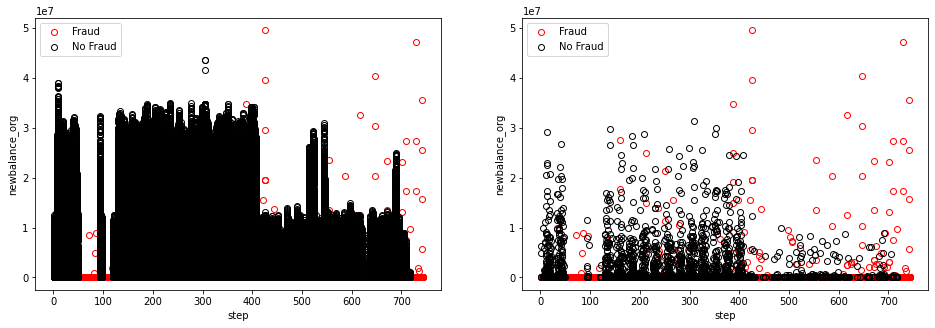

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
for d, k in zip([df, df_samp], [0, 1]):
    ax[k].scatter(d[msk]['step'], d[msk]['newbalance_orig'], **args_b(linewidth=1))
    ax[k].scatter(d[~msk]['step'], d[~msk]['newbalance_orig'], **args_b(linewidth=1, edgecolor='k'))
    ax[k].legend(['Fraud', 'No Fraud'])
    ax[k].set_xlabel('step')
    ax[k].set_ylabel('newbalance_org');

### 1.8.2. Categorical Attributes

#### 1.8.2.1. Sample Dataset

In [25]:
_, cat_att = metrics(df_samp, split=True)

cat_values = [cat_att[k].value_counts().to_dict() for k in cat_att.columns.tolist()]

In [28]:
cat_att.describe()

,type,name_orig,name_dest
count,14181,14181,14181
unique,5,14181,14057
top,CASH_OUT,C486135548,C721605153
freq,6044,1,2


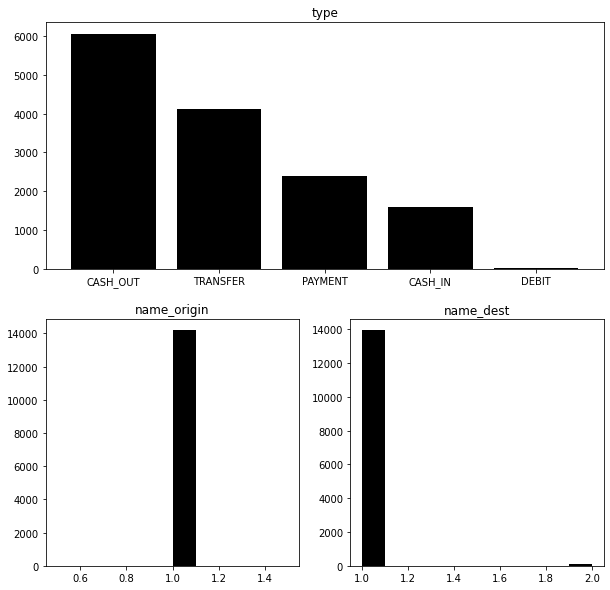

In [26]:
simple_plot_bars(cat_values);

#### 1.8.2.2. Full Dataset

In [29]:
_, cat_att = metrics(df, split=True)

cat_values = [cat_att[k].value_counts().to_dict() for k in cat_att.columns.tolist()]

In [31]:
cat_att.describe()

,type,name_orig,name_dest
count,5408227,5408227,5408227
unique,5,5401432,2382129
top,CASH_OUT,C724452879,C985934102
freq,1900990,3,97


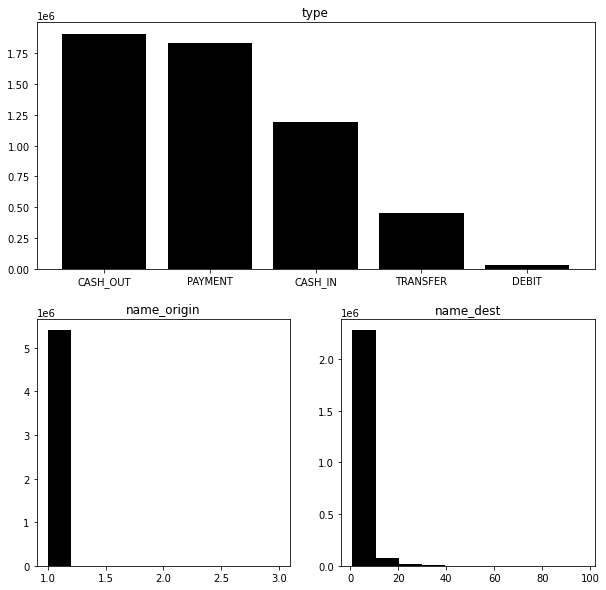

In [30]:
simple_plot_bars(cat_values);

In [74]:
(df.loc[df.type == 'CASH_OUT']).is_fraud.value_counts().to_dict()

{0: 1897480, 1: 3510}

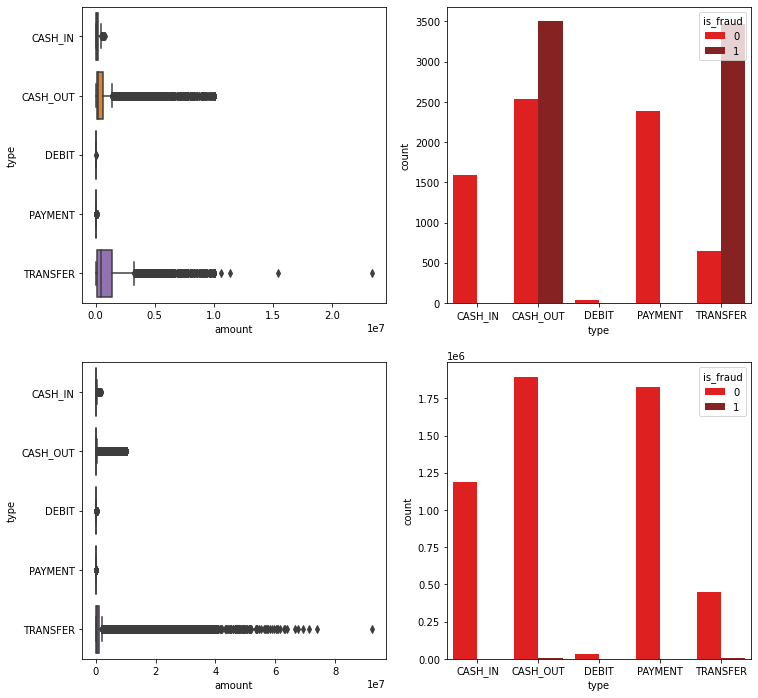

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
for d, i in zip([df_samp, df], [[0, 1], [2, 3]]):
    sns.boxplot(d.amount, d.type, ax=ax[i[0]]);
    sns.countplot(d.type, hue=d.is_fraud, ax=ax[i[1]], palette=palette);

1. Debit is the lowest payment type basend on all 64kk rows.
2. Have people on Dataset with more than one transaction.
3. Have people with +50 Transactions!

In [75]:
# The Client C985934102 have 97 Transactions, all transactions are legitimate
(df.loc[df.name_dest == 'C985934102']).is_fraud.value_counts().to_dict()

{0: 97}

In [49]:
df[['name_orig', 'is_fraud']].groupby('name_orig').count().reset_index().sort_values('is_fraud', ascending=False).head(4)

,name_orig,is_fraud
3622106,C363736674,3
2189496,C1784010646,3
3724238,C400299098,3
2325136,C1832548028,3


In [48]:
df[['name_dest', 'is_fraud']].groupby('name_dest').count().reset_index().sort_values('is_fraud', ascending=False).head(4)

,name_dest,is_fraud
549279,C985934102,97
310094,C2083562754,95
81877,C1286084959,94
6747,C1023714065,88


# 2.0. Feature Engineering 

In [4]:
df2 = pd.read_csv("../data_backup/df_train.csv", dtype=dtypes)
df2 = df2.drop('Unnamed: 0', axis=1)

## 2.1. Mind Map

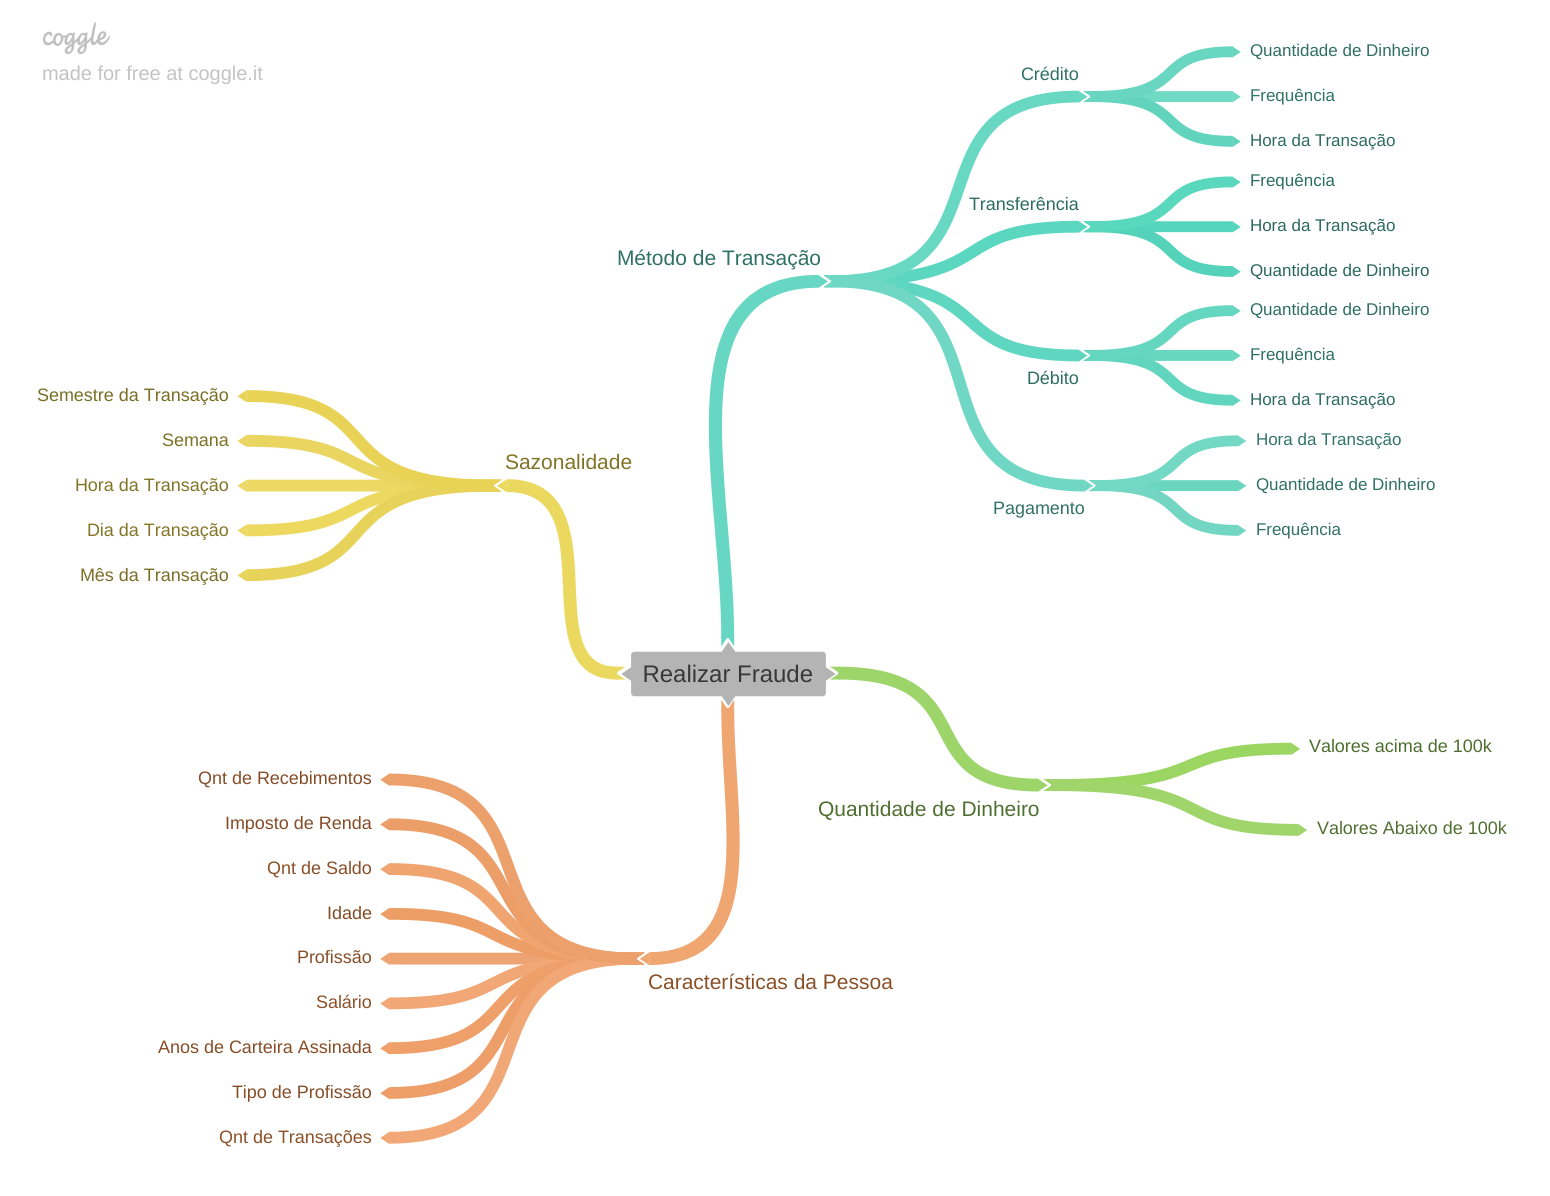

## 2.2. Hypothesis List 

**H1.** Transações em debito representam mais de 50% dos casos de fraude.

**H2.**  Transações depois do dia 20 do mês representam 20% mais casos de fraudes.

**H3.** Transações realizadas a mercantes representam 10% das fraudes.

**H4.** Em 50% dos casos de fraude, a transação de origem limpa toda a conta.

**H5.** As transações fraudulentas acontecem em transações com até 2m.

**H6.** Os fraudadores atuam em duas ou mais fraudes por semana.

**H7.** A flag de fraude consegue capturar 50% de todas as transações fraudulentas.

**H8.** 80% dos casos de fraudes acontecem quando o destino da transação já possui dinheiro na conta.

## 2.3. Feature Engineering

1. **Day** Feature is the Step (1 Hour) / 24 Hours up round.<br>
    Why: To transform Step feature in day.
    
2. **Merchant** Feature is Merchant flag for future als.<br>
    Why: Only to have a simple access to merchant clients.

3. **Amount per Day** Amount per simulation days.<br>
    Why: I will use i think :p

4. **Difference Orig** Feature based on difference between Origin Features and Amount.<br>
    Why: Because have **0** median and min is **0** in some features in dataset. 

5. **Difference Dest** Feature based on difference ans sum of new amount and difference in dest.<br>
    Why: Because have **0** median and min is **0** in some features in dataset.


In [5]:
# Day Feature
df2['day'] = np.ceil(df2.step / 24).astype('int16')

# Merchant Flag
df2['merch_flag'] = df2['name_dest'].apply(lambda x: 1 if x.startswith("M") else 0)

# Amount Features
df2['amount_per_day'] = df2['amount'] / df2['day']

df2['diff_org'] = df2['oldbalance_org'] - df2['amount'] - df2['newbalance_orig']

df2['diff_dest'] = df2['oldbalance_dest'] + df2['amount'] - df2['newbalance_dest']

In [39]:
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,day,merch_flag,diff_org,diff_dest,amount_per_day
0,153,PAYMENT,6180.080078,C1832989767,690.00,0.00,M384940439,0.00,0.0,0,0,7,1,-5490.080078,6180.080078,882.868591
1,300,CASH_IN,79904.578125,C1139898348,7638719.50,7718624.00,C1347516418,236157.28,156252.7,0,0,13,0,-159809.078125,159809.158125,6146.505859
2,234,CASH_OUT,187892.843750,C92484418,30222.00,0.00,C1424238302,772647.75,960540.6,0,0,10,0,-157670.843750,-0.006250,18789.285156
3,131,CASH_OUT,30502.250000,C1917111010,178209.78,147707.53,C479231807,1084921.00,1115423.2,0,0,6,0,0.000000,0.050000,5083.708496
4,377,CASH_OUT,287481.187500,C1326454589,151223.00,0.00,C221094956,0.00,287481.2,0,0,16,0,-136258.187500,-0.012500,17967.574219


In [40]:
df2.to_csv('../data_backup/df_train.csv')

In [82]:
df_s = pd.read_csv("../data_backup/df_samp.csv", index_col=0)

# Day Feature
df_s['day'] = np.ceil(df_s.step / 24).astype('int16')

# Merchant Flag
df_s['merch_flag'] = df_s['name_dest'].apply(lambda x: 1 if x.startswith("M") else 0)

# Amount Features
df_s['amount_per_day'] = df_s['amount'] / df_s['day']

df_s['diff_org'] = df_s['oldbalance_org'] - df_s['amount'] - df_s['newbalance_orig']

df_s['diff_dest'] = df_s['oldbalance_dest'] + df_s['amount'] - df_s['newbalance_dest']

df_s.to_csv("../data_backup/df_samp.csv")

# 3.0. Data Filtering

1. In Next Cycle, clean Number 0 of Transactions!

In [31]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [38]:
# Amount Price Filters
df3 = df3.loc[df3.amount < 3e7]

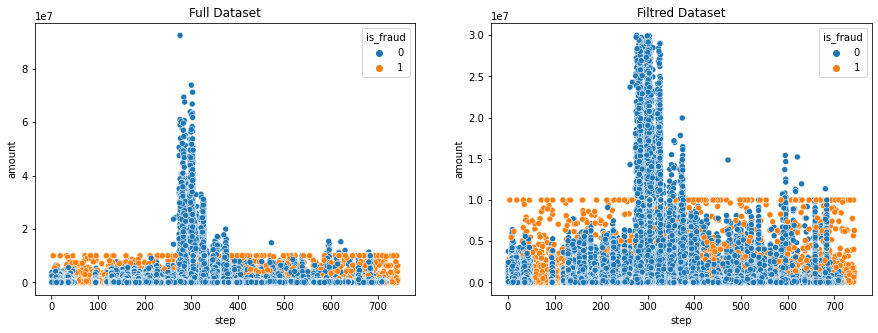

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(df2.step, df2.amount, hue=df2.is_fraud, ax=ax[0]);
sns.scatterplot(df3.step, df3.amount, hue=df3.is_fraud, ax=ax[1]);
ax[0].set_title("Full Dataset")
ax[1].set_title("Filtred Dataset");

In [45]:
df3.to_csv("../data_backup/up/df_train.csv")

## 3.2. Filtering Columns

In [ ]:
df3 = df3.drop('step', axis=1)

# 4.0. Exploratory Data Analysis 

In [493]:
dtypes = {
    'type': 'category',
    'amount': 'float32',
    'name_orig': 'object',
    'oldbalance_org': 'float32',
    'newbalance_orig': 'float32',
    'name_dest': 'object',
    'oldbalance_dest': 'float32',
    'newbalance_dest': 'float32',
    'is_fraud': 'uint8',
    'is_flagged_fraud': 'uint8',
    'day': 'int16',
    'merch_flag': 'uint8',
    'diff_org': 'float32',
    'diff_dest': 'float32',
    'amount_per_day': 'float32'}

df4 = pd.read_csv("../data_backup/df_train.csv", dtype=dtypes, index_col=0)
msk = (df4.is_fraud == 1)
df4.head()

,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,day,merch_flag,diff_org,diff_dest,amount_per_day
0,PAYMENT,6180.080078,C1832989767,6.900000e+02,0.000000e+00,M384940439,0.000000e+00,0.000000e+00,0,0,7,1,-5490.080078,6180.080078,882.868591
1,CASH_IN,79904.578125,C1139898348,7.638720e+06,7.718624e+06,C1347516418,2.361573e+05,1.562527e+05,0,0,13,0,-159809.078125,159809.156250,6146.505859
2,CASH_OUT,187892.843750,C92484418,3.022200e+04,0.000000e+00,C1424238302,7.726478e+05,9.605406e+05,0,0,10,0,-157670.843750,-0.006250,18789.285156
3,CASH_OUT,30502.250000,C1917111010,1.782098e+05,1.477075e+05,C479231807,1.084921e+06,1.115423e+06,0,0,6,0,0.000000,0.050000,5083.708496
4,CASH_OUT,287481.187500,C1326454589,1.512230e+05,0.000000e+00,C221094956,0.000000e+00,2.874812e+05,0,0,16,0,-136258.187500,-0.012500,17967.574219


## 4.1. Univariable Analysis

### 4.1.1. Response Variable

In [18]:
(df4.is_fraud.value_counts() / len(df4)).to_dict()

{0: 0.9987091140872433, 1: 0.0012908859127567487}

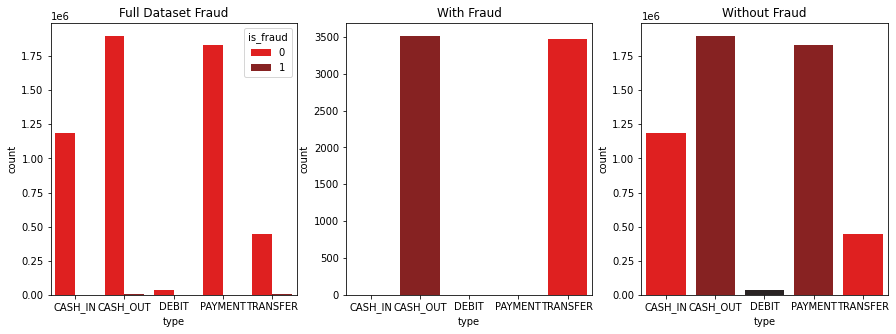

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

sns.countplot(df4.type, hue=df4.is_fraud, palette=palette, ax=ax[0]);
ax[0].set_title("Full Dataset Fraud");

for k in zip([df4[msk], df4[~msk]], [1, 2], ['With Fraud', 'Without Fraud']):
    sns.countplot(k[0].type, palette=palette, ax=ax[k[1]]);
    ax[k[1]].set_title(k[2]);

### 4.1.2. Numeric Variables

In [14]:
df_s = pd.read_csv("../data_backup/df_samp.csv", index_col=0)
df_s = df_s.reset_index(drop=True)
num_att = (df_s.select_dtypes(include=['int64', 'float64'])).drop("step", axis=1)
num_att = np.log1p(num_att)
num_att.diff_org = num_att.diff_org.astype("str").replace("-inf", '0').astype('float32')
num_att.diff_dest = num_att.diff_dest.astype("str").replace("-inf", '0').astype('float32')

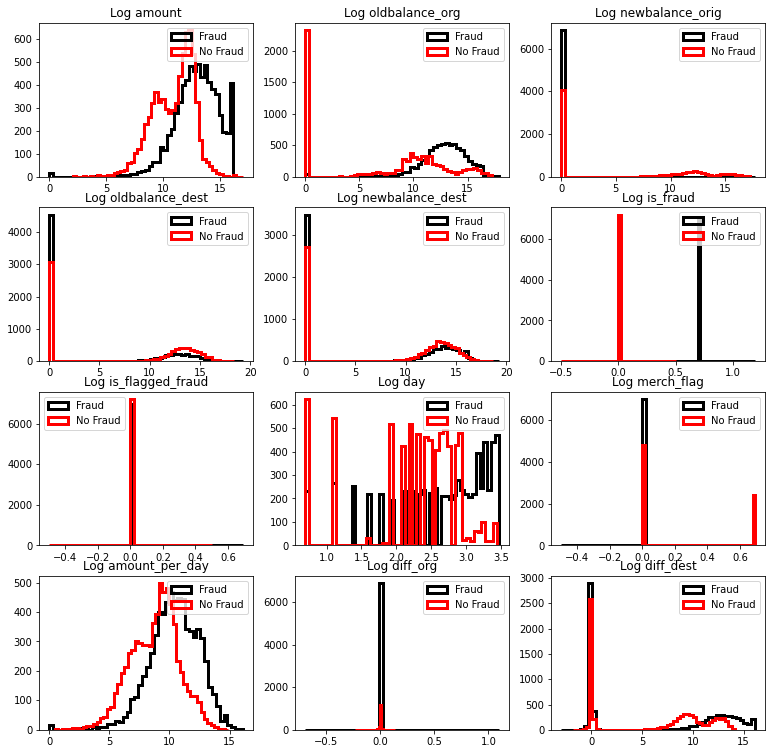

In [129]:
fig, ax = plt.subplots(4, 3, figsize=(13, 13))
ax = ax.flatten()
for k, i in zip(num_att.columns.tolist(), range(0, num_att.shape[1])):
    ax[i].hist(num_att[msk][k], **args(bins=50, c='k', label="Fraud"))
    ax[i].hist(num_att[~msk][k], **args(bins=50, c='r', label="No Fraud"))
    ax[i].set_title(f"Log {k}")
    ax[i].legend()

In [61]:
a, b = metrics(df4, split=True)

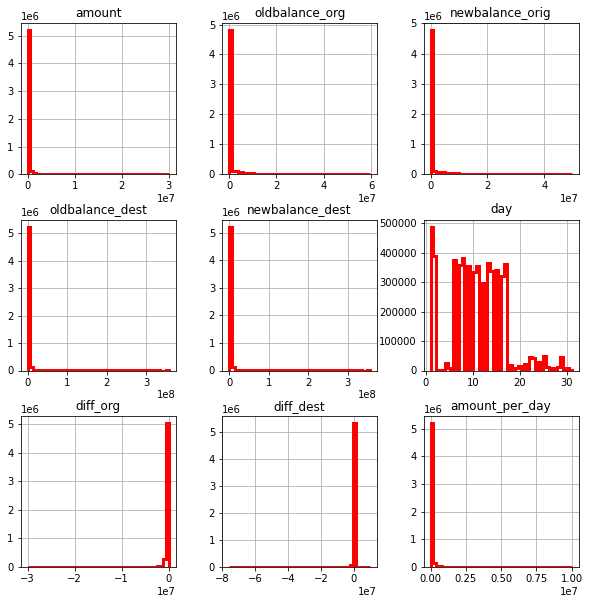

In [79]:
a.hist(**args(bins=50), figsize=(10,10));

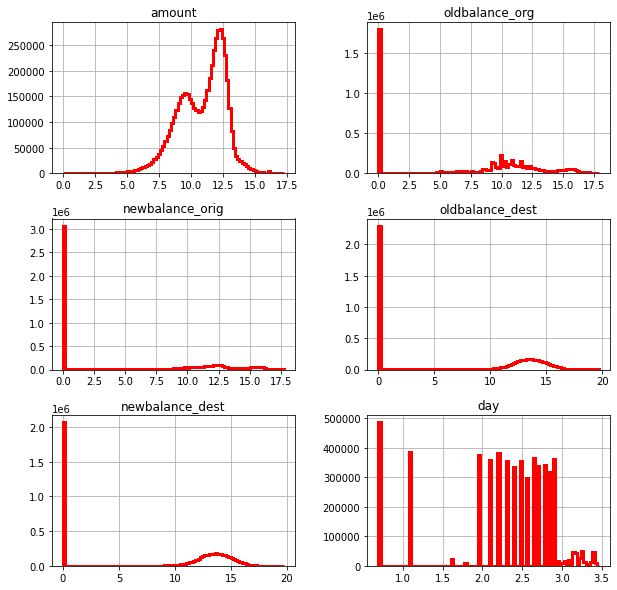

In [93]:
np.log1p(a).fillna(0).iloc[:, :-3].hist(**args(bins=100), figsize=(10,10));

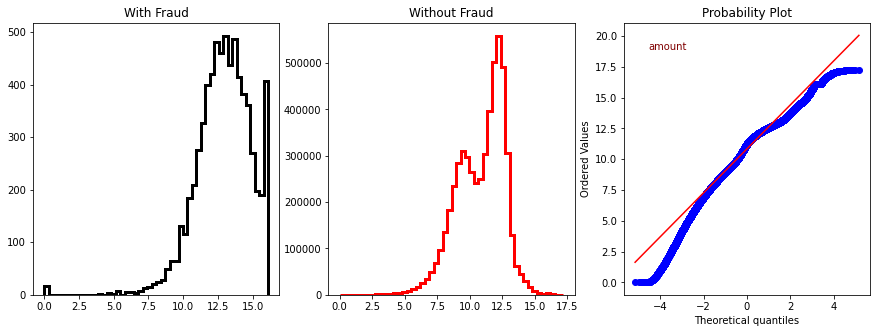

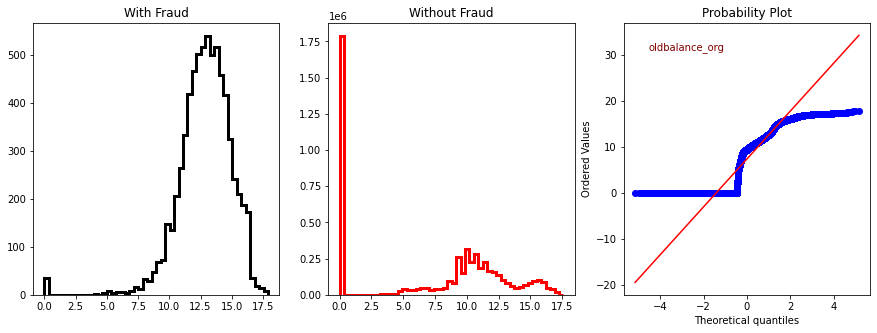

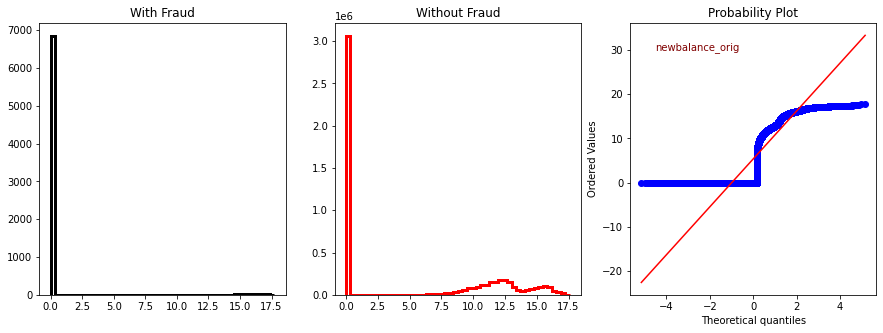

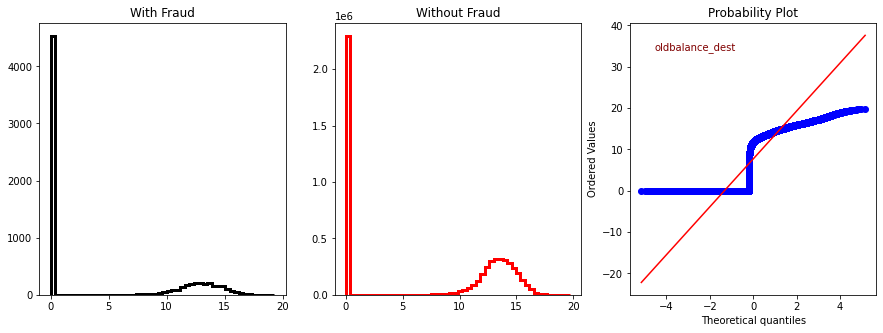

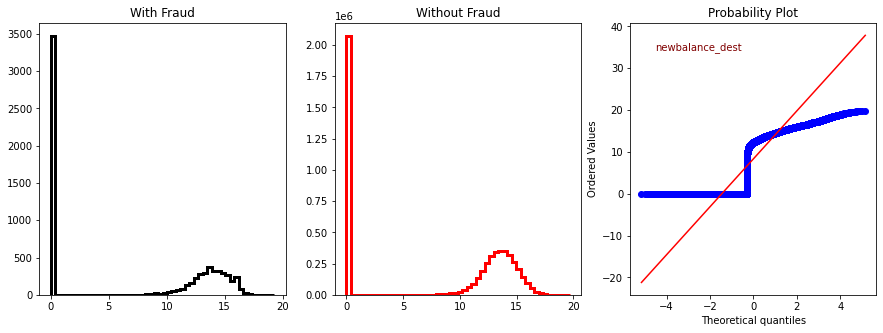

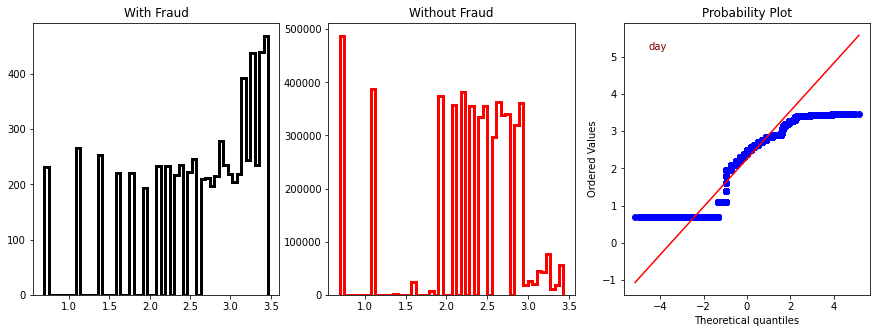

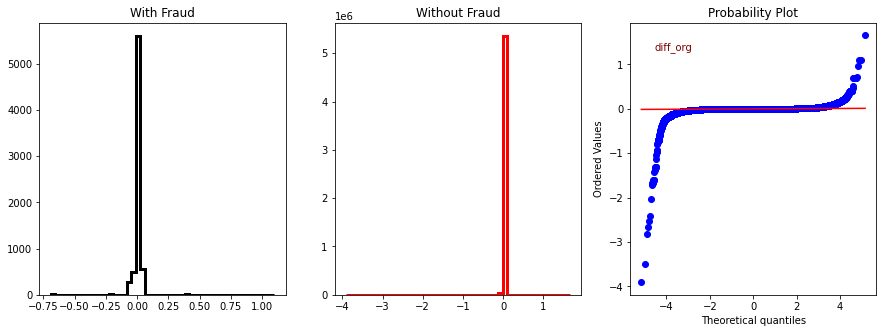

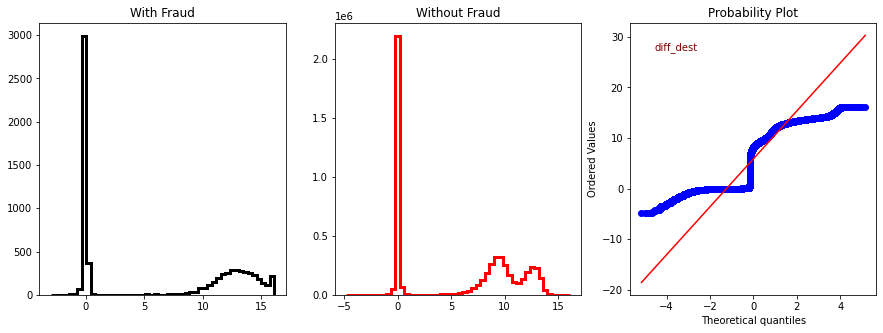

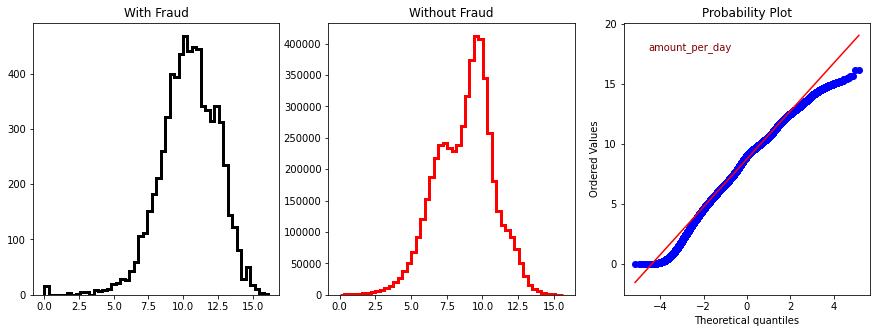

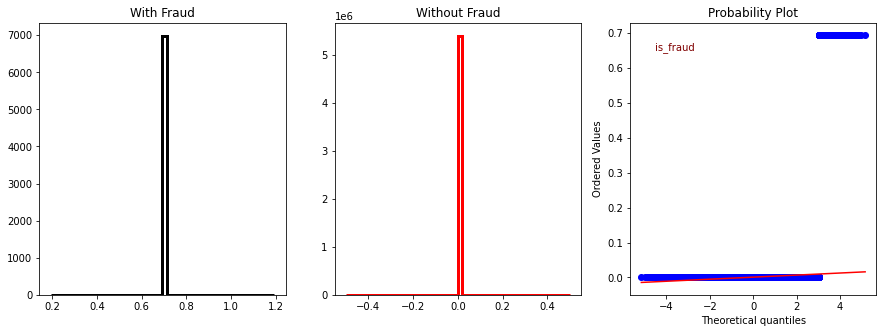

In [69]:
plot_qq(a)

### 4.1.3. Categorical Variables

In [97]:
b.describe()

,type,name_orig,name_dest
count,5407914,5407914,5407914
unique,5,5401121,2382129
top,CASH_OUT,C400299098,C985934102
freq,1900990,3,97


### 4.1.4. Variables per Target

In [5]:
a, b = metrics(df4, split=True)
a = pd.concat([a, df4.is_fraud], axis=1)

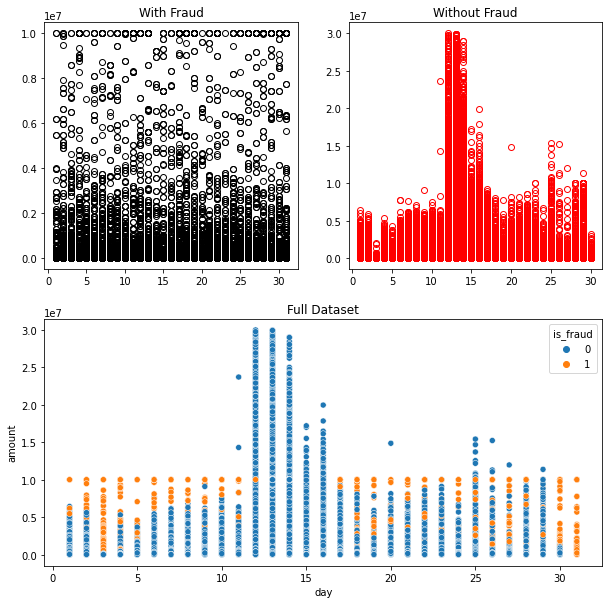

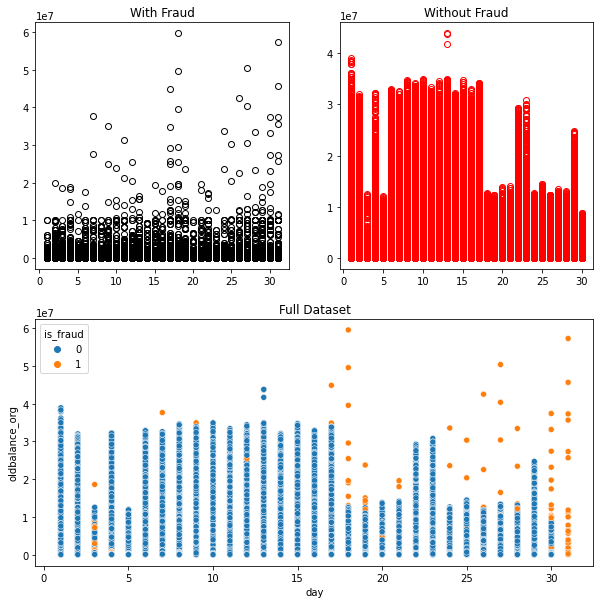

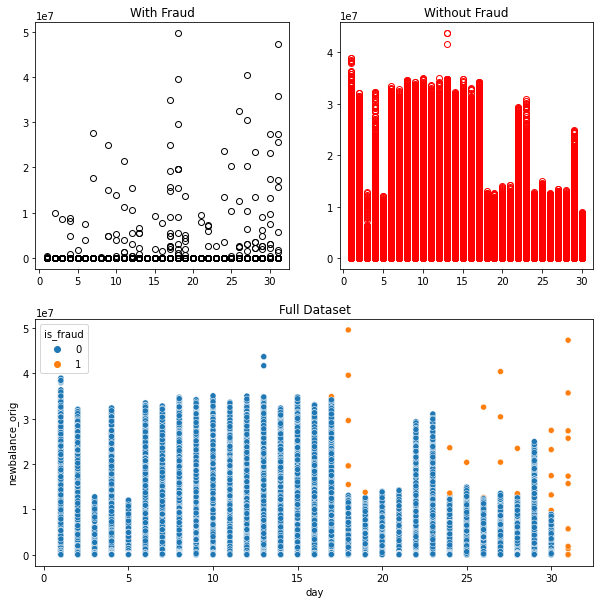

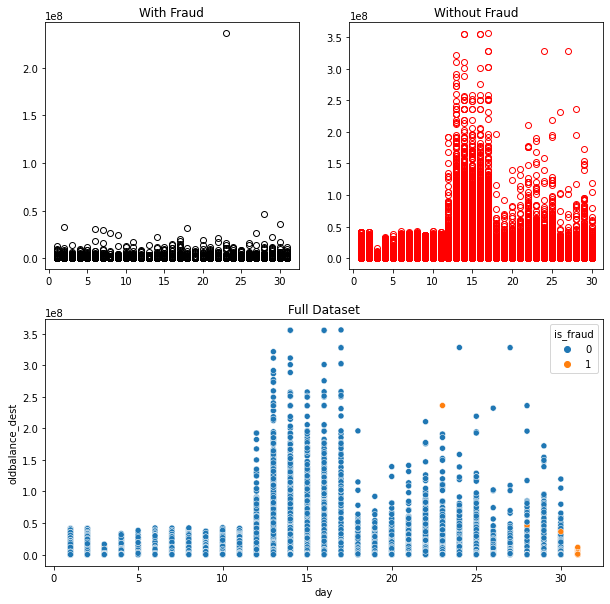

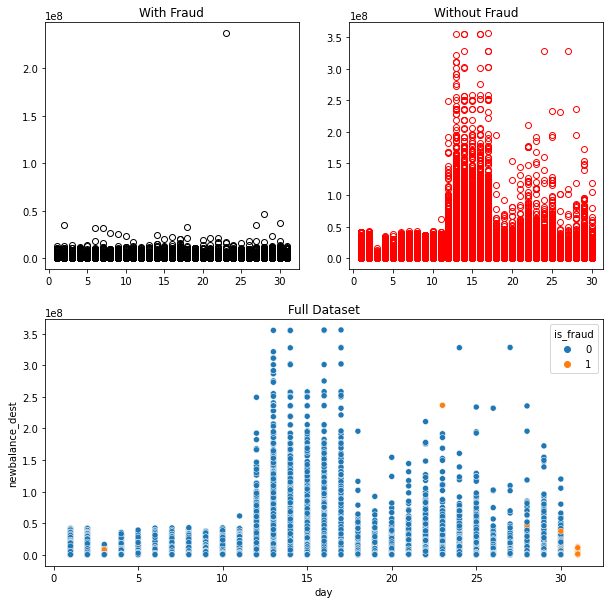

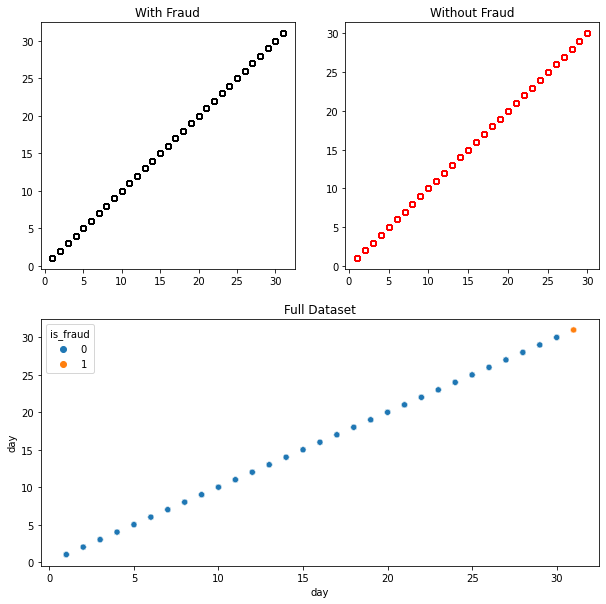

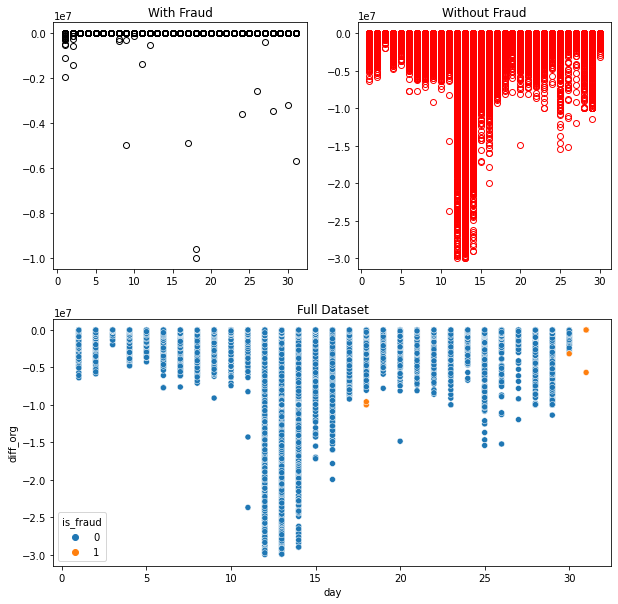

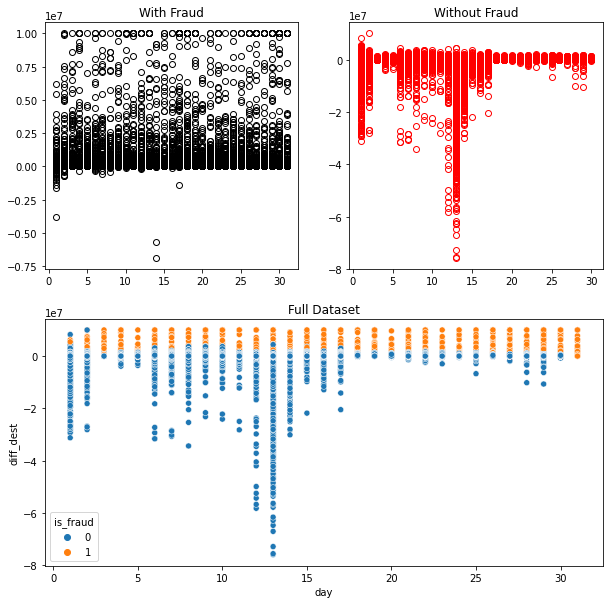

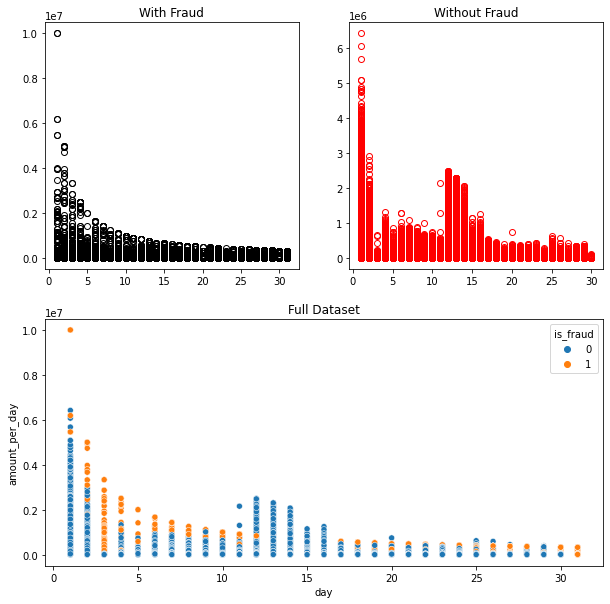

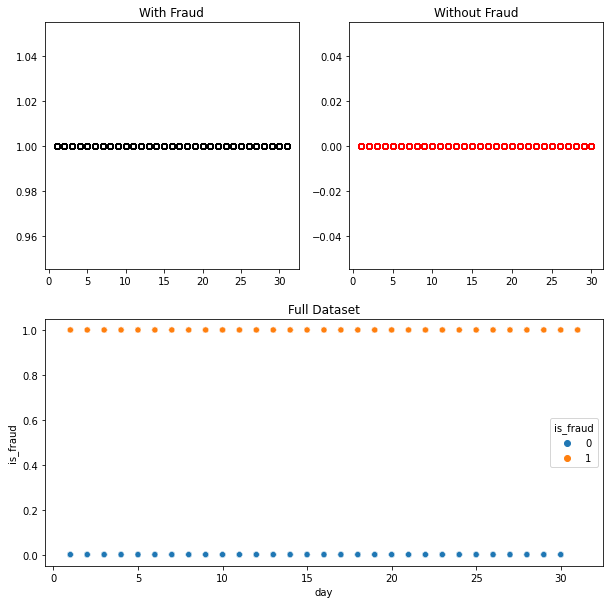

In [17]:
for k in a.columns.tolist():
    plot_vars(a, k)

## 4.2. Bivariable Analysis

### **H1.** Transações em debito representam mais de 50% dos casos de fraude.
**Falso** Apenas existem transações fraudulentas do tipo "Cash Out" e "Transaction".

In [137]:
aux1 = df4[msk][['is_fraud', 'type']].groupby("type").count().reset_index()
aux2 = df4[msk][['is_fraud', 'type', 'day']].groupby(['type', 'day']).count().reset_index()
aux2 = aux2[aux2.is_fraud > 0]
aux3 = df4[~msk][['is_fraud', 'type']].groupby('type').count().reset_index()
aux4 = df4[msk][['is_fraud', 'type', 'amount']]

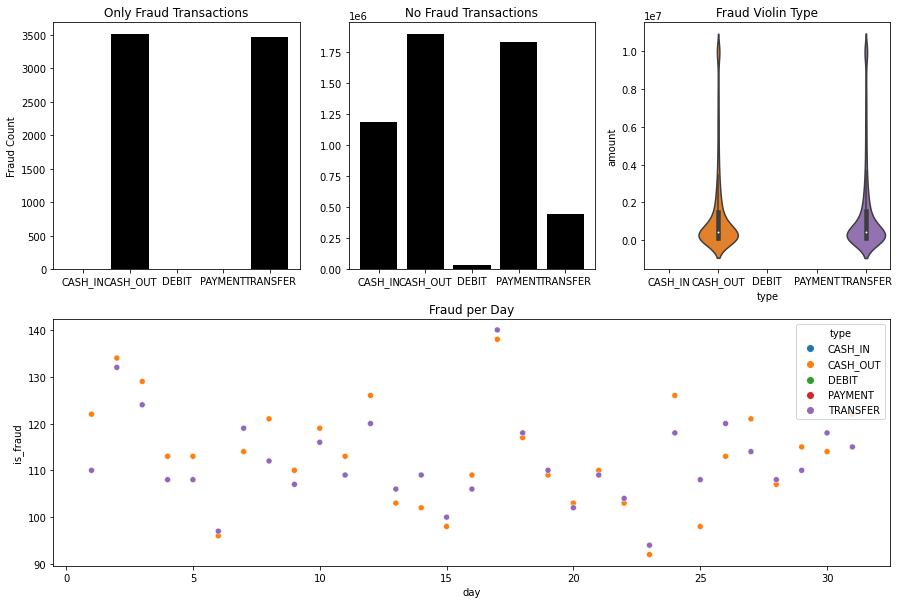

In [139]:
plot_trans_type(aux1, aux2, aux3, aux4)

### **H2.** Transações depois do dia 20 do mês representam 20% mais casos de fraudes.

**Verdadeiro** Transações após o dia 20 do mês representa 38% de novos casoa de fraude.

In [193]:
aux1 = df4[msk].copy()
aux1['before_days'] = df4.day.apply(lambda x: 'After' if x < 20 else 'Before')

aux2 = aux1[['is_fraud', 'before_days']].groupby('before_days').count().reset_index()
aux3 = aux1[['amount', 'day']].groupby('day').sum().reset_index()

aux4 = df4.copy()
aux4 = aux4[['amount', 'is_fraud']].groupby('is_fraud').sum().reset_index()

In [226]:
(aux2.is_fraud / aux2.is_fraud.sum()).to_dict()

{0: 0.62125769946999, 1: 0.37874230053001}

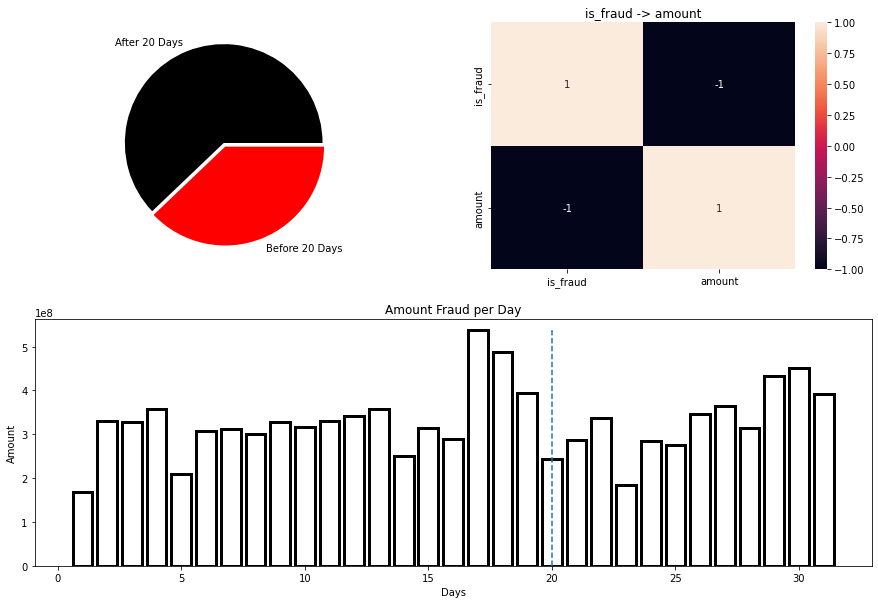

In [240]:
plot_before_days(aux2, aux3, aux4)

### **H3.** Transações realizadas a mercantes representam 10% das fraudes.

**Falso** Não existe transações fraudulentas a mercantes.

In [249]:
df4[(df4.merch_flag == 1) & (df4.is_fraud == 1)]

,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,day,merch_flag,diff_org,diff_dest,amount_per_day


### **H4.** Em 50% dos casos de fraude, a transação de origem limpa toda a conta.

**Verdadeiro** Na Maioria dos casos de Fraude os mesmos retiram todo o dinheiro da conta.

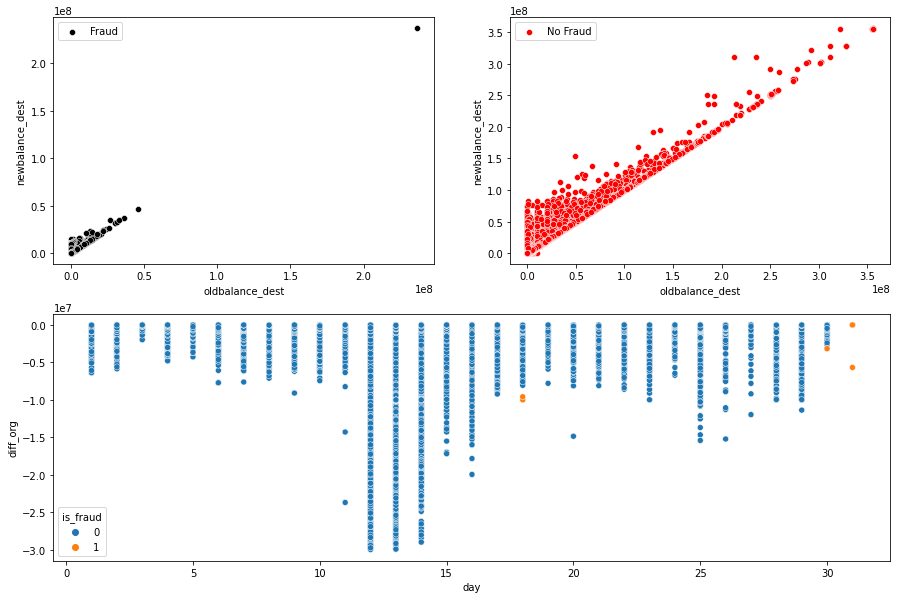

In [291]:
_, _, plt.subplots(figsize=(15,10))
ax0 = plt.subplot2grid((2,2), (0,0))
ax1 = plt.subplot2grid((2,2), (0,1))
ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)

sns.scatterplot(df4[msk].oldbalance_dest, df4[msk].newbalance_dest, color='k', label='Fraud', ax=ax0)
sns.scatterplot(df4[~msk].oldbalance_dest, df4[~msk].newbalance_dest, color='r', label='No Fraud', ax=ax1)
sns.scatterplot(df4.day, df4.diff_org, hue=df4.is_fraud, ax=ax2);

### **H5.** As transações fraudulentas acontecem em transações com até 2m.

**Verdadeiro** A fraude e o comportamento do novo banaço da origem também é muito diferente.

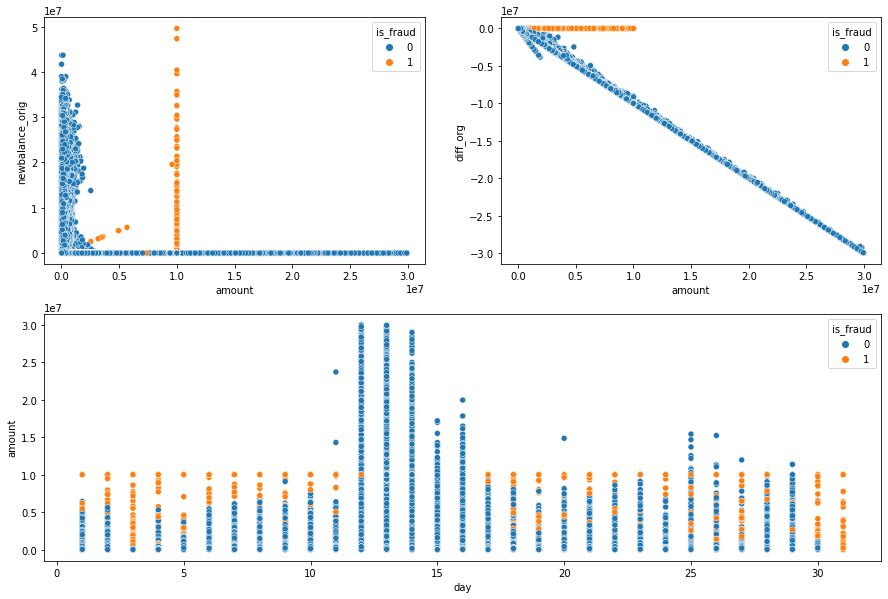

In [309]:
_, _, plt.subplots(figsize=(15,10))
ax0 = plt.subplot2grid((2,2), (0,0))
ax1 = plt.subplot2grid((2,2), (0,1))
ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)

sns.scatterplot(df4.amount, df4.newbalance_orig, hue=df4.is_fraud, ax=ax0)
sns.scatterplot(df4.amount, df4.diff_org, hue=df4.is_fraud, ax=ax1)
sns.scatterplot(df4.day, df4.amount, hue=df4.is_fraud, ax=ax2);

### **H6.** Os fraudadores atuam em duas ou mais fraudes por semana.

**Verdadeiro** Existem apenas alguns fraudadores que atuam mais de uma vez durante a semana.


In [389]:
pd.DataFrame([len(df4[msk]['name_orig'].unique()), len(df4[msk]['name_dest'].unique())]).T.rename(columns={0:'U. Origin', 1:'U. Dest'})

,U. Origin,U. Dest
0,6981,6948


In [399]:
df4[msk].loc[df4[msk]['name_dest'].duplicated()].shape

(33, 15)

In [429]:
duplicated_origin = df4[msk].loc[df4[msk]['name_dest'].duplicated()]['name_dest'].tolist()
aux1 = pd.DataFrame(columns=df4.columns.tolist())

for k in duplicated_origin:
    aux1 = pd.concat([aux1, df4.loc[df4.name_dest == k]], axis=0)

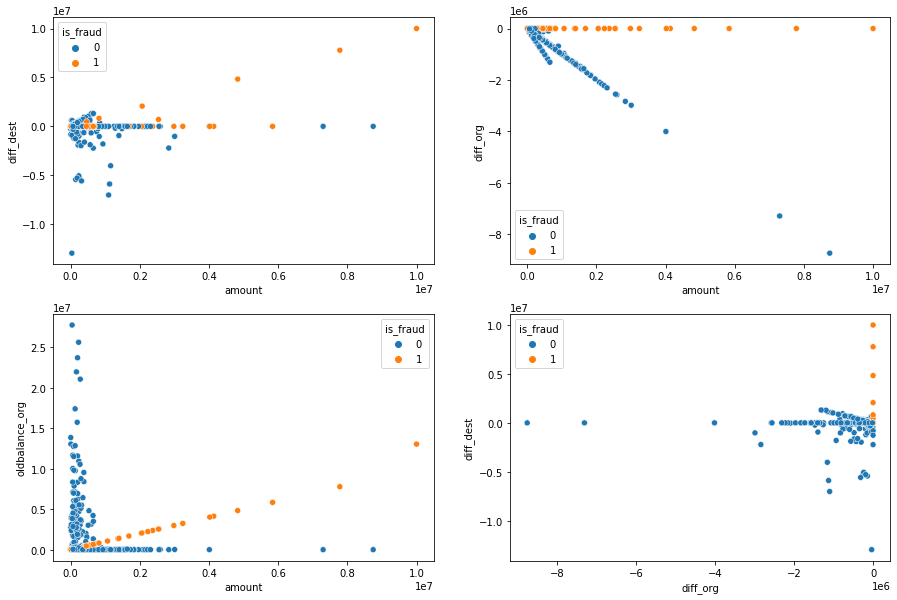

In [447]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()
for a, x, y in zip(ax, ['amount']*3 + ['diff_org'], ['diff_dest','diff_org','oldbalance_org','diff_dest']):
    sns.scatterplot(aux1[x], aux1[y], hue=df4.is_fraud, ax=a)

In [416]:
df4.loc[df4.name_dest == 'C1497532505']

,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,day,merch_flag,diff_org,diff_dest,amount_per_day
633186,CASH_OUT,601657.250000,C1756674752,6.016572e+05,0.00,C1497532505,127078.820312,728736.06250,1,0,9,0,0.000000,0.010000,66850.804688
688406,CASH_OUT,143175.234375,C1950513519,1.431752e+05,0.00,C1497532505,695647.187500,838822.43750,1,0,13,0,-0.004375,-0.005625,11013.479492
1372635,CASH_OUT,3714.530029,C1929214791,0.000000e+00,0.00,C1497532505,406724.718750,410439.25000,0,0,11,0,-3714.530029,0.000029,337.684540
1827838,CASH_OUT,219396.281250,C167532086,8.891000e+03,0.00,C1497532505,0.000000,219396.28125,0,0,7,0,-210505.281250,0.001250,31342.326172
3141079,CASH_IN,282482.843750,C445785069,3.691429e+06,3973911.75,C1497532505,689207.562500,406724.71875,0,0,10,0,-564965.625000,564965.687500,28248.285156
3758922,CASH_OUT,248834.156250,C1531533126,0.000000e+00,0.00,C1497532505,440373.437500,689207.56250,0,0,9,0,-248834.156250,0.036250,27648.240234
5038040,TRANSFER,154345.468750,C1231890773,0.000000e+00,0.00,C1497532505,594320.187500,748665.62500,0,0,15,0,-154345.468750,0.068750,10289.698242
5198777,CASH_IN,244502.234375,C1221727381,5.531434e+06,5775937.00,C1497532505,838822.437500,594320.18750,0,0,15,0,-489004.750000,489004.468750,16300.149414
5311794,CASH_OUT,229560.703125,C584495431,2.224904e+05,0.00,C1497532505,748665.625000,978226.37500,0,0,16,0,-7070.312988,-0.096875,14347.543945


### **H7.** A flag de fraude consegue capturar 50% de todas as transações fraudulentas.

**Falso** A Flag de fraude apenas captura 0.001% de todas as fraudes.

In [457]:
a=(df4[['is_fraud', 'is_flagged_fraud']].groupby('is_fraud').count().reset_index().is_flagged_fraud / len(df4)).to_dict()
a

{0: 0.9987091140872433, 1: 0.0012908859127567487}

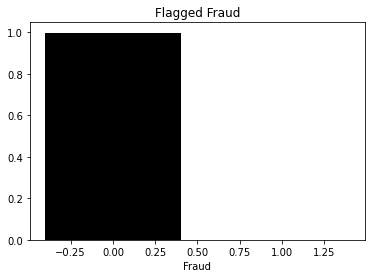

In [464]:
plt.bar(a.keys(), a.values(), color='k');
plt.title("Flagged Fraud");
plt.xlabel("Fraud");

### **H8.** 80% dos casos de fraudes acontecem quando o destino da transação já possui dinheiro na conta.

**Falso** Apenas 35% de todos os casos de fraude possuem dinheiro na origem quando a fraude ocorreu.

In [533]:
df4[msk][df4[msk].oldbalance_dest > 0].shape[0] / df4[msk].shape[0]

0.35066609368285345

In [498]:
bins = list(np.arange(0.00, 10.1e5, 5e4))
aux1 = df4[msk].copy()
aux1['cut_dest'] = pd.cut(aux1['oldbalance_dest'], bins=bins)

In [509]:
aux2 = aux1[['cut_dest', 'amount']].groupby("cut_dest").sum().reset_index()

In [543]:
aux3 = df4[['amount', 'is_fraud']]
aux3['cut_amount'] = pd.cut(aux3.amount, bins=bins)

aux31 = aux3[['amount', 'is_fraud', 'cut_amount']].groupby(['cut_amount', 'is_fraud']).count().reset_index()
no_fraud_sum = aux31[aux31.is_fraud == 0]['amount'].sum()
fraud_sum = aux31[aux31.is_fraud == 1]['amount'].sum()

aux31['percentage'] = aux31.apply(lambda x: (x['amount'] / fraud_sum) if x['is_fraud'] == 1 else (x['amount'] / no_fraud_sum), axis=1)

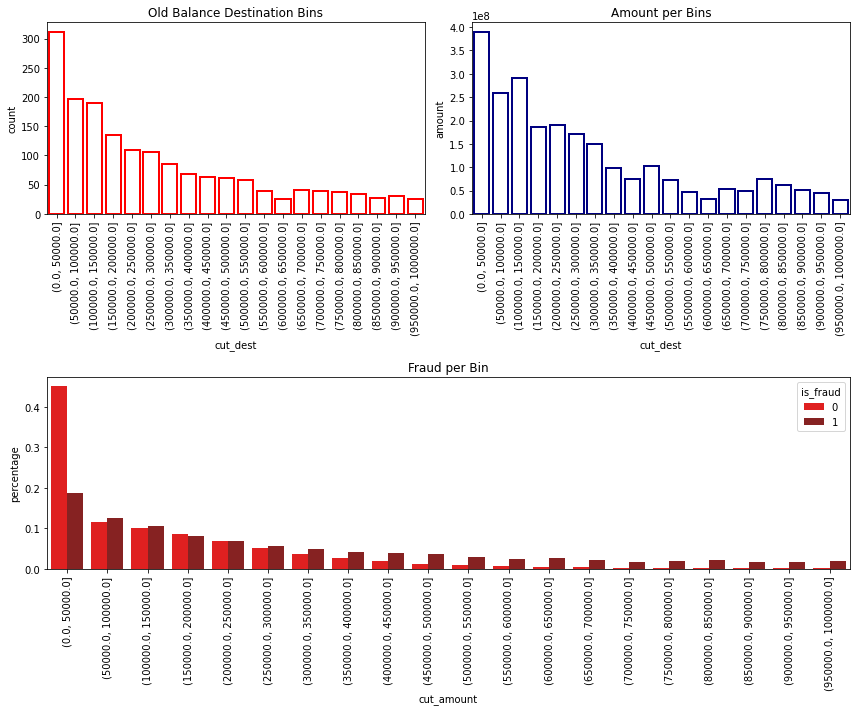

In [560]:
plot_dest_amount(aux1, aux2, aux31)

## 4.3. Multivariable Analysis

### 4.3.1. Correlation Heatmaps

Text(0.5, 1.0, 'Heatmap Pearson Corr')

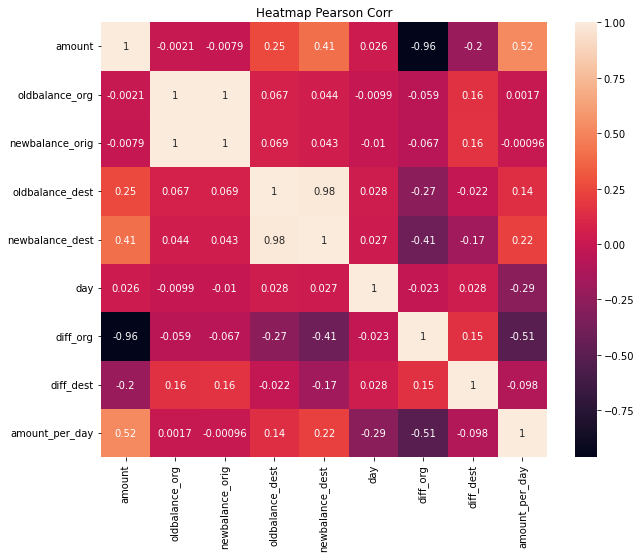

In [570]:
a, b = metrics(df4, split=True)

_, _, plt.subplots(figsize=(10,8))
sns.heatmap(a.corr(), annot=True).set_title("Heatmap Pearson Corr")

### 4.3.2. Pairplots

Next Cycle

# 5.0. Dataset Preparation

1. I have chosen the first sample datasetto continue in this first cycle.

In [145]:
df5 = pd.read_csv("../data_backup/df_samp.csv", index_col=0)
df5 = df5.drop(['name_orig', 'name_dest'], axis=1)

## 5.1. Normalization

Do Not exists normal Features on Dataset.

## 5.2. Rescaling

In [148]:
rs = RobustScaler()
mms = MinMaxScaler()

df5['amount'] = rs.fit_transform(df5[['amount']])
pickle.dump( rs, open("amount_scaler.pkl", "wb") )

df5['diff_org'] = rs.fit_transform(df5[['diff_org']])
pickle.dump( rs, open("diff_org_scaler.pkl", "wb") )

df5['diff_dest'] = rs.fit_transform(df5[['diff_dest']])
pickle.dump( rs, open("diff_dest_scaler.pkl", "wb") )

df5['amount_per_day'] = rs.fit_transform(df5[['amount_per_day']])
pickle.dump( rs, open("amount_per_day_scaler.pkl", "wb") )

df5['oldbalance_org'] = rs.fit_transform(df5[['oldbalance_org']])
pickle.dump( rs, open("oldbalance_org_scaler.pkl", "wb") )

df5['oldbalance_dest'] = rs.fit_transform(df5[['oldbalance_dest']])
pickle.dump( rs, open("oldbalance_dest_scaler.pkl", "wb") )

df5['newbalance_orig'] = rs.fit_transform(df5[['newbalance_orig']])
pickle.dump( rs, open("newbalance_orig_scaler.pkl", "wb") )

df5['newbalance_dest'] = rs.fit_transform(df5[['newbalance_dest']])
pickle.dump( rs, open("newbalance_dest_scaler.pkl", "wb") )


## 5.3. Transformation

### 5.3.1. Encoding 

In [149]:
# Type (Frequency Encoding)

f_type = df5.groupby('type').size() / len(df5)
df5.type = df5.type.apply(lambda x: f_type[x])

### 5.3.2. Nature Transformation  

In [73]:
# Day (Sin and Cos)

df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi / 7 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi / 7 ) ) )

## 5.4. Final Dataset

1. newbalance_orig need checkout

In [74]:
df5 = df5.drop('day', axis=1)

df5 = df5[['type','amount','oldbalance_org','newbalance_orig','oldbalance_dest','newbalance_dest','merch_flag','amount_per_day','diff_org','diff_dest','day_sin','day_cos','is_flagged_fraud','is_fraud']]

In [75]:
df5.head()

,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,merch_flag,amount_per_day,diff_org,diff_dest,day_sin,day_cos,is_flagged_fraud,is_fraud
0,0.426204,0.471062,-0.110051,0.0,1.027031,0.753402,0,3.296098,-4.918080,-0.019530,0.974928,-0.222521,0,0
1,0.112404,-0.171232,10.858359,8625644.0,0.292290,-0.058101,0,-0.111670,-2.229393,1.033222,0.974928,-0.222521,0,0
2,0.426204,0.352579,-0.147733,0.0,4.509906,2.036313,0,0.739240,-4.525703,2.043920,-0.781831,0.623490,0,0
3,0.426204,0.180869,-0.069689,0.0,0.005039,0.131770,0,0.296068,-2.622237,-0.019530,0.781831,0.623490,0,0
4,0.168253,-0.280047,-0.142453,0.0,0.000000,-0.116471,1,0.269292,-0.352973,0.172239,0.781831,0.623490,0,0


In [76]:
df5.to_csv("../data_backup/df_prep.csv")

# 6.0. Feature Selection

1. Test a Extra Tree for feature importance for Noise

In [86]:
df6 = df5.copy()

In [87]:
X = df6.iloc[:, :-1]
Y = df6.iloc[:, -1]

## 6.1. Tree-Based Feature Selection 

### 6.2.1. XGBoost Feature Importance

In [88]:
rf = RandomForestClassifier(n_jobs=-1).fit(X.values, Y.values)

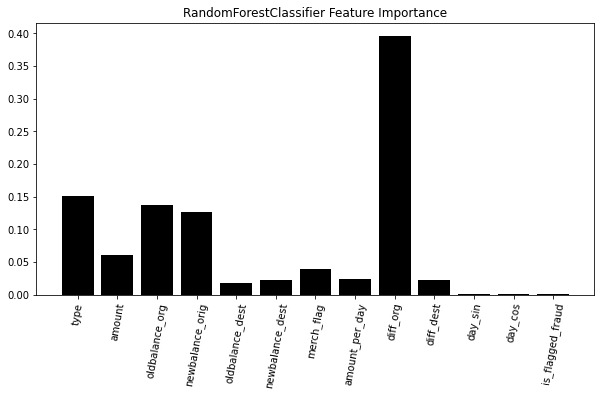

In [123]:
get_features_importance(rf, X)

### 6.1.2. Random Forest Feature Importance

In [91]:
xg = XGBClassifier(n_jobs=-1).fit(X.values, Y.values)

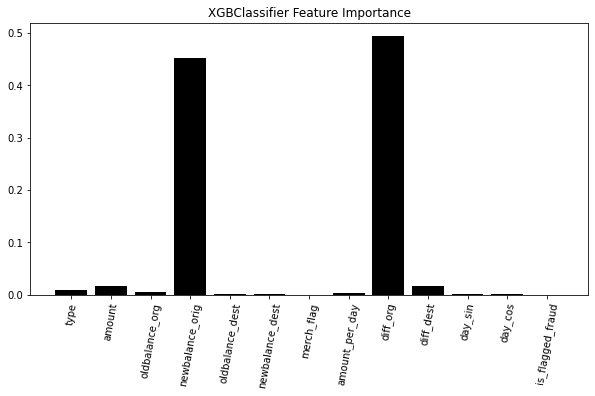

In [125]:
get_features_importance(xg, X)

## 6.2. Boruta Feature Importance

Next Cycle

## 6.3. Manual Feature Selection

In [5]:
c=['type', 
   'amount', 
   'oldbalance_org', 
   'newbalance_orig', 
   'newbalance_dest', 
   'diff_org', 
   'diff_dest', 
   'merch_flag', 
   'is_fraud']

In [136]:
df61 = df6[c]

In [138]:
df61.head()

,type,amount,oldbalance_org,newbalance_orig,newbalance_dest,diff_org,diff_dest,merch_flag,is_fraud
0,0.426204,0.471062,-0.110051,0.0,0.753402,-4.918080,-0.019530,0,0
1,0.112404,-0.171232,10.858359,8625644.0,-0.058101,-2.229393,1.033222,0,0
2,0.426204,0.352579,-0.147733,0.0,2.036313,-4.525703,2.043920,0,0
3,0.426204,0.180869,-0.069689,0.0,0.131770,-2.622237,-0.019530,0,0
4,0.168253,-0.280047,-0.142453,0.0,-0.116471,-0.352973,0.172239,1,0


# 7.0. Machine Learning Models

In [3]:
df7 = pd.read_csv("../data_backup/df_prep.csv", index_col=0)

df_test = pd.read_csv("../data_backup/df_test.csv", index_col=0)

df_train_full = pd.read_csv("../data_backup/df_train.csv", index_col=0)

c=['type', 'amount', 'oldbalance_org', 'newbalance_orig', 'newbalance_dest', 'diff_org', 'diff_dest', 'merch_flag', 'is_fraud']

## 7.1. Dataset Preparation

### 7.1.1. Train and Validation

In [4]:
df7 = df7[c]

X = df7.iloc[:, :-1]
Y = df7.iloc[:, -1]

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=.10)

### 7.1.2. Test Dataset

In [6]:
df_test.columns = [underscore(x) for x in df_test.columns]

df_test = feature_engineering(df_test)

df_test = df_test[c]

df_test = data_preparation(df_test)

x_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

### 7.1.3. Full Train Dataset

In [7]:
# df_train_full.columns = [underscore(x) for x in df_train_full.columns]

# df_train_full = feature_engineering(df_train_full)

df_train_full = df_train_full[c]

df_train_full = data_preparation(df_train_full)

x_train_full = df_train_full.iloc[:, :-1]
y_train_full = df_train_full.iloc[:, -1]

## 7.1. Baseline Model

In [12]:
yhat_random = choices(population=[0,1], k=y_train.shape[0])

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Random Choices,0.492164,0.492222,0.485822,0.489001


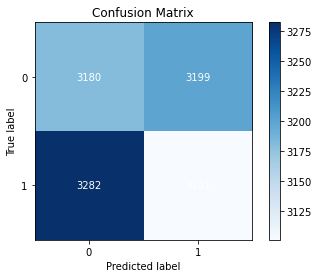

In [42]:
ml_error("Random Choices", yhat_random, y_train)

## 7.2. SGD 

In [179]:
sg = SGDClassifier(loss='log', n_jobs=-1).fit(x_train, y_train)

### 7.2.1. SGD Validation

In [180]:
yhat_cls = sg.predict(x_valid)
yhat_prb = sg.predict_proba(x_valid)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,SGDClassifier,0.914729,0.864234,0.954839,0.90728


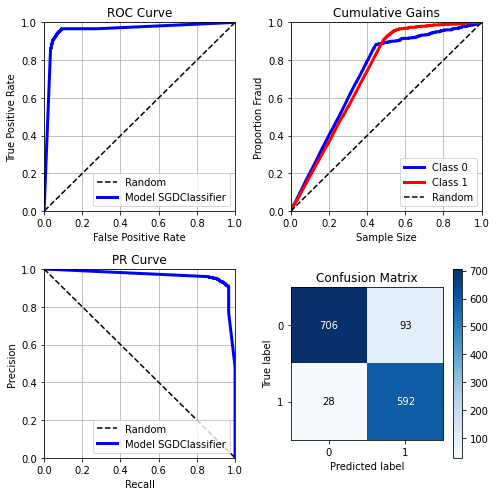

In [181]:
ml_error(type(sg).__name__, y_valid, yhat_cls, yhat_prb, True)

### 7.2.1. SGD Test 

In [182]:
yhat_test_cls = sg.predict(x_test)
yhat_test_prb = sg.predict_proba(x_test)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,SGDClassifier,0.963937,0.883929,0.030794,0.059515


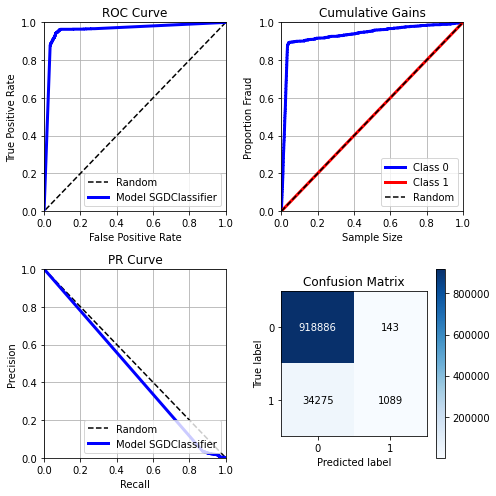

In [183]:
ml_error(type(sg).__name__, y_test, yhat_test_cls, yhat_test_prb, True)

## 7.3. LGBM

In [192]:
lg = LGBMClassifier(n_jobs=-1).fit(x_train, y_train)

### 7.3.1. LGBM Validation

In [193]:
yhat_cls = lg.predict(x_valid)
yhat_prb = lg.predict_proba(x_valid)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,LGBMClassifier,0.999295,0.99854,1.0,0.99927


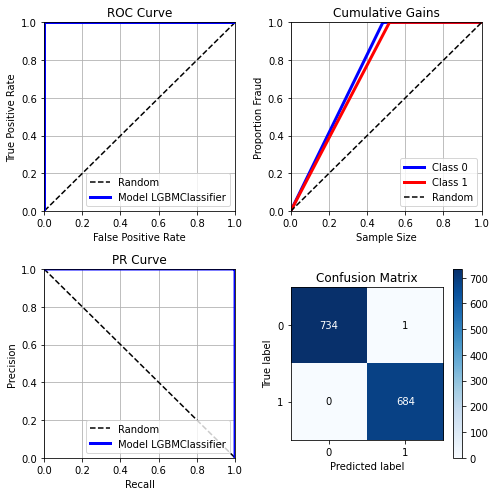

In [194]:
ml_error(type(lg).__name__, y_valid, yhat_cls, yhat_prb, True)

### 7.3.2. LGBM Test

In [195]:
yhat_test_cls = lg.predict(x_test)
yhat_test_prb = lg.predict_proba(x_test)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,LGBMClassifier,0.999086,0.99513,0.586042,0.737665


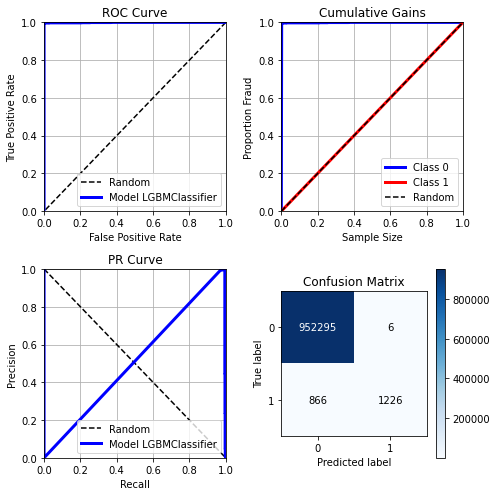

In [196]:
ml_error(type(lg).__name__, y_test, yhat_test_cls, yhat_test_prb, True)

## <font color='blue'> 7.4. XGBoost </font>

In [11]:
xg = XGBClassifier(n_jobs=-1).fit(x_train_full, y_train_full)

### 7.4.1. XGBoost Validation 

In [12]:
yhat_cls = xg.predict(x_valid)
yhat_prb = xg.predict_proba(x_valid)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,XGBClassifier,0.998591,0.997294,1.0,0.998645


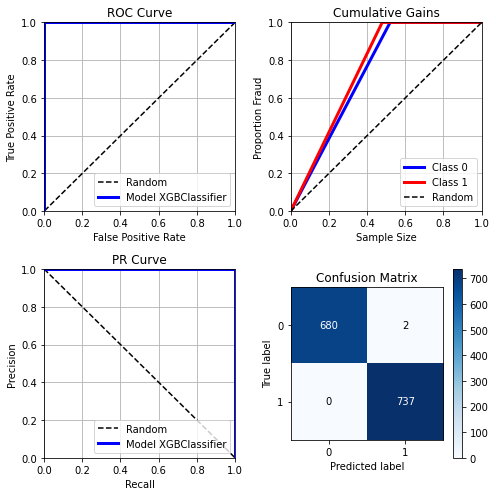

In [13]:
ml_error(type(xg).__name__, y_valid, yhat_cls, yhat_prb, True)

### 7.4.2. XGBoost Test 

In [14]:
yhat_test_cls = xg.predict(x_test)
yhat_test_prb = xg.predict_proba(x_test)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,XGBClassifier,0.999994,0.99513,1.0,0.997559


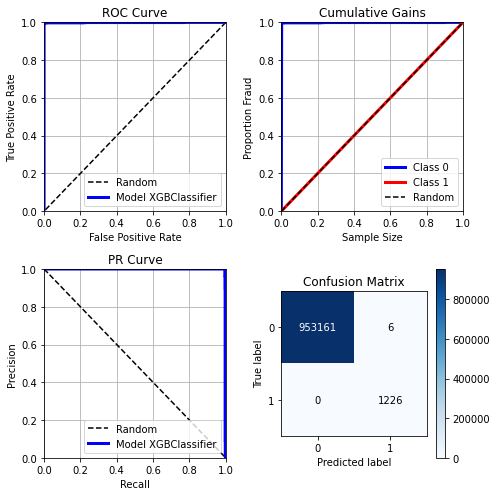

In [16]:
ml_error(type(xg).__name__, y_test, yhat_test_cls, yhat_test_prb, True)

## 7.5. Random Forest

In [12]:
rf = RandomForestClassifier(n_jobs=-1).fit(x_test, y_test)

### 7.5.1. Random Forest Validation

In [13]:
yhat_cls = rf.predict(x_valid)
yhat_prb = rf.predict_proba(x_valid)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,XGBClassifier,0.998591,0.997015,1.0,0.998505


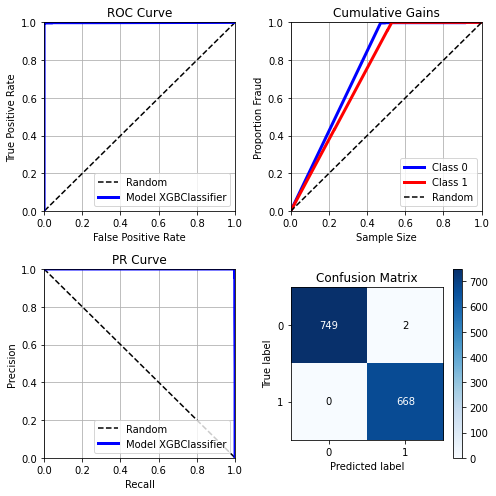

In [14]:
ml_error(type(xg).__name__, y_valid, yhat_cls, yhat_prb, True)

### 7.5.2. Random Forest Test

In [15]:
yhat_test_cls = xg.predict(x_train)
yhat_test_prb = xg.predict_proba(x_train)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,XGBClassifier,0.997884,0.995722,1.0,0.997856


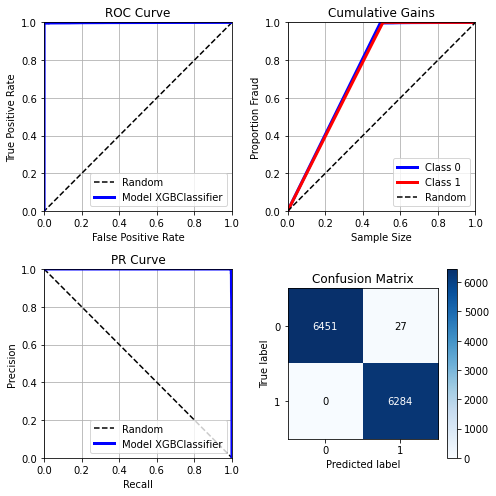

In [16]:
ml_error(type(xg).__name__, y_train, yhat_test_cls, yhat_test_prb, True)